In [28]:
library(Seurat)
library(ggplot2)
library(dplyr)
library(conos)
library(biomaRt)
library(pagoda2)

In [29]:
# Subset whole Seurat dataset and fetch sympatho-adrenal cells

adrenal_whole = new.env()
adrenal_whole$SR = readRDS('../data/seurat/adrenal.human.seurat.scrublet.rds')

adrenal_medulla = new.env()
adrenal_medulla$SR = adrenal_whole$SR[,adrenal_whole$SR@meta.data$fate == 'medulla']

rm(adrenal_whole)
gc()

l_cluster_annotation = list(24,
                            33,
                            c(0,41,22),
                            c(22,40)
                           )
names(l_cluster_annotation) = c('SCP', 'cycling', 'sympathoblasts', 'chromaffin')

adrenal_medulla$SR@meta.data$fate = 'other'

for(i in 1:length(l_cluster_annotation)){
    adrenal_medulla$SR@meta.data$fate[adrenal_medulla$SR@meta.data$seurat_clusters %in% l_cluster_annotation[[i]] ] = names(l_cluster_annotation)[i]
}



used      (Mb)   gc trigger (Mb)   max used   (Mb)  
Ncells   4942829  264.0    8161484  435.9    8161484  435.9
Vcells 170690465 1302.3 1014614772 7740.9 1249340789 9531.8

# Remove batch effects with conos

In [52]:
# Make a per-sample list of raw count matrices from Seurat object

l_raw_counts = list()


for(sample in c("R30_w85", "R39_w95", "R48a_w145", "R48b_w120", "R48c_w85", "R53a_w95", "R53b_w115", "R53c_w95", "R62_w85")){
    if(sum(adrenal_medulla$SR@meta.data$orig.ident == sample)>=50){
        l_raw_counts[[sample]] = adrenal_medulla$SR@assays$RNA@counts[,adrenal_medulla$SR@meta.data$orig.ident == sample]
        print(sample)
    }
}


[1] "R30_w85"
[1] "R39_w95"
[1] "R48a_w145"
[1] "R48b_w120"
[1] "R48c_w85"
[1] "R53a_w95"
[1] "R53b_w115"
[1] "R53c_w95"
[1] "R62_w85"


In [53]:
# Vector of cell annotations (fate)

rfate.f = adrenal_medulla$SR@meta.data$fate
names(rfate.f) = rownames(adrenal_medulla$SR@meta.data)

In [32]:
#fetch cell cycle genes

ensembl = biomaRt::useMart("ensembl",dataset="hsapiens_gene_ensembl")
cc.genes <- biomaRt::getBM(attributes = c('entrezgene_id','hgnc_symbol'), filters = 'go', values = c('GO:0000278','GO:0006260','GO:0007049'), mart = ensembl)


In [33]:
head(cc.genes)

entrezgene_id hgnc_symbol
1 220134        SKA1       
2 494551        WEE2       
3 203068        TUBB       
4  56992        KIF15      
5     NA        MCPH1      
6   7278        TUBA3C

In [54]:
#Preprocess each count matrix with pagoda2

l_pagoda2preproc <- lapply(l_raw_counts, function(cd) {
  cd <- cd[!rownames(cd) %in% cc.genes[,2], ]
  basicP2proc(cd, n.cores=1, nPcs=20, min.cells.per.gene=0, n.odgenes=1e3, get.largevis=TRUE,get.tsne=TRUE,make.geneknn=FALSE)
})


403 cells, 25283 genes; normalizing ... using plain model winsorizing ... log scale ... done.
calculating variance fit ... using gam 117 overdispersed genes ... 117persisting ... done.
running PCA using 1000 OD genes .... done
Estimating embeddings.
running tSNE using 1 cores:
991 cells, 25283 genes; normalizing ... using plain model winsorizing ... log scale ... done.
calculating variance fit ... using gam 239 overdispersed genes ... 239persisting ... done.
running PCA using 1000 OD genes .... done
Estimating embeddings.
running tSNE using 1 cores:
264 cells, 25283 genes; normalizing ... using plain model winsorizing ... log scale ... done.
calculating variance fit ... using gam 128 overdispersed genes ... 128persisting ... done.
running PCA using 1000 OD genes .... done
Estimating embeddings.
running tSNE using 1 cores:
251 cells, 25283 genes; normalizing ... using plain model winsorizing ... log scale ... done.
calculating variance fit ... using gam 69 overdispersed genes ... 69pers

In [55]:
#vi <- !grepl("R62_w85|R43_w60",names(l_raw_counts))


conC3 <- Conos$new(l_pagoda2preproc, n.cores=30);
conC3$buildGraph(k=30, k.self=5, space='PCA', ncomps=20, n.odgenes=1000, verbose=TRUE)
#conC3$buildGraph(k=30, k.self=10, space='PCA', ncomps=20, n.odgenes=2000, verbose=TRUE,base.groups = fate.f,append.decoys = F,append.global.axes = T)
#conC3$misc$embeddings$UMAP <- conC3$embedGraph(method='UMAP',spread=15,n.neighbors=100)#,min.dist=2,n.neighbors=100,spread=15);
conC3$misc$embeddings$lv <- conC3$embedGraph(sgd_batches=1e8,alpha=0.01);
conC3$findCommunities(method=leiden.community,resolution=1)

found 0 out of 36 cached PCA  space pairs ... running 36 additional PCA  space pairs  done
inter-sample links using  mNN   done
local pairs local pairs  done
building graph ..done
Estimating embeddings.


In [56]:
# Run UMAP on conos graph
set.seed(1)
conC3$misc$embeddings$UMAP <- conC3$embedGraph(method='UMAP', min.dist=0.001, spread=30, n.cores=40, min.prob.lower=1e-5,n.neighbors=200)

Convert graph to adjacency list...
Done
Estimate nearest neighbors and commute times...
Estimating hitting distances: 02:33:48.
Done.
Estimating commute distances: 02:33:49.
Hashing adjacency list: 02:33:49.
Done.
Estimating distances: 02:33:49.
Done
Done.
All done!: 02:33:49.
Done
Estimate UMAP embedding...


Warning message in embedKnnGraph(commute.times, n.neighbors = n.neighbors, names = adj.info$names, :
“Maximal number of estimated neighbors is 15. Consider increasing min.visited.verts, min.prob or min.prob.lower.
”
02:33:49 UMAP embedding parameters a = 0.008928 b = 0.7905

02:33:49 Read 5189 rows and found 1 numeric columns

02:33:50 Commencing smooth kNN distance calibration using 40 threads

02:33:51 Initializing from normalized Laplacian + noise

02:33:51 Commencing optimization for 1000 epochs, with 106250 positive edges using 40 threads

02:33:56 Optimization finished



Done


In [44]:
emb <- conC3$misc$embeddings$UMAP
write.table(emb, file='../data/embeddings/adrenal_medulla.human.conos.csv', row.names=T, col.names=F, sep=',', quote=F)

In [ ]:
rp1 <- function(n) { set.seed(1); sample(rainbow(n)) }
conC3$embedding <- conC3$misc$embeddings$UMAP
#conC3$embedding <- conC3$misc$embeddings$lv
#conC3$embedding <- r.cdl$embedding
alpha <- 0.2; size <- 0.5;
p1 <- conC3$plotGraph(groups=rfate.f,raster=F,alpha=alpha,size=size,title='UMAP',font.size=c(3,4),palette=rp1)
conC3$embedding <- conC3$misc$embeddings$lv
p2 <- conC3$plotGraph(groups=rfate.f,raster=F,alpha=alpha,size=size,title='largeVis',font.size=c(3,4),palette=rp1)
p <- cowplot::plot_grid(plotlist=list(p1,p2), nrow=1)
p

# Use conos embedding with the Seurat object

UMAP_1    UMAP_2  
R30_w8.5_AAACGAAGTAGGGAGG-1  9.576523 3.586374
R30_w8.5_AAACGCTGTATTCCGA-1  9.732390 4.119824
R30_w8.5_AAAGGATTCTAGCATG-1  9.683136 3.571521
R30_w8.5_AAATGGAGTGCGACAA-1 13.005676 3.720688
R30_w8.5_AAATGGAGTTCTAACG-1 10.163564 7.512005
R30_w8.5_AACAAAGTCTTTGCGC-1 13.138337 4.066019

X6.44146652137083 X.98.540284911027
R39_w9.5_AAACCCAAGTATGGCG-1 34.802112         -112.46328       
R30_w8.5_ATGCCTCTCGCATAGT-1 13.347243         -100.16087       
R30_w8.5_CACTAAGTCATCGCAA-1  1.605501          -92.77246       
R30_w8.5_CAGCCAGTCATCACAG-1 -3.434032          -86.17790       
R30_w8.5_CCCTGATAGCAAGGAA-1 -1.258604          -88.78788       
R30_w8.5_CGTGATATCGCCCAGA-1 35.580420         -109.65973

[1] 3869

[1] 0

[1] 26105 10312

[1] 26105  3869

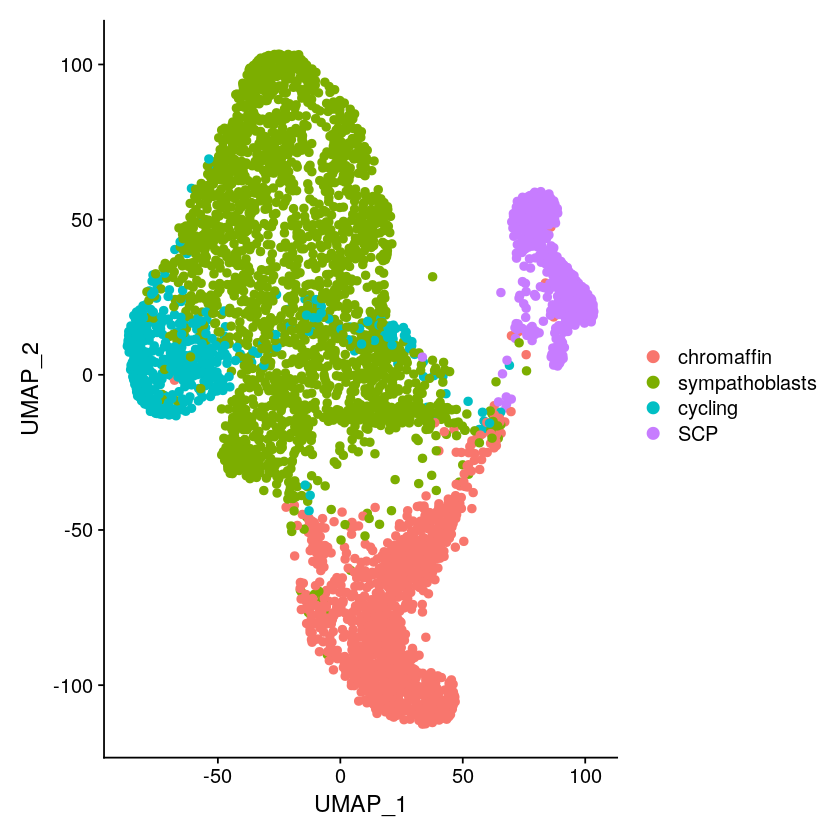

In [18]:
head(adrenal_medulla$SR@reductions$umap@cell.embeddings)
#Loading UMAP embedding from conos

emb_conos = read.csv('../data/embeddings/adrenal_medulla.human.conos.csv', row.names=1)

head(emb_conos)


length(intersect(rownames(emb_conos), colnames(adrenal_medulla$SR)))
length(setdiff(rownames(emb_conos), colnames(adrenal_medulla$SR)))

#stopifnot(all(rownames(emb_scanpy) == colnames(adrenal_medulla$SR)))

dim(adrenal_medulla$SR)
adrenal_medulla$SR = adrenal_medulla$SR[,rownames(emb_conos)]
dim(adrenal_medulla$SR)


m_embedding = as.matrix(emb_conos[colnames(adrenal_medulla$SR),1:2])
colnames(m_embedding) = c('UMAP_1', 'UMAP_2')
adrenal_medulla$SR@reductions$umap@cell.embeddings = m_embedding

Idents(adrenal_medulla$SR) = 'fate'
DimPlot(adrenal_medulla$SR, reduction = 'umap', pt.size = 2)

# Manually select cells from bridges

Needs JS, runs in jupyter notebook (does not support jupyter lab)

In [42]:
library(rbokeh)

figure(legend_location=NULL) %>% ly_points(UMAP_1, UMAP_2,
                       data = adrenal_medulla$SR@reductions$umap@cell.embeddings,
                       color=adrenal_medulla$SR@meta.data$fate,
                       lname = 'points') %>%
 tool_lasso_select(custom_callback(
        "var inds = cb_obj.get('selected')['1d'].indices;
        var d1 = cb_obj.get('data');
        console.log(inds.join());
        console.log(cb_obj.get('selected')['1d']);
        console.log(window.top.IPython.notebook.kernel.id);
        window.top.IPython.notebook.kernel.execute('selected=\"'+inds.join()+'\"');
        "), ref_layer='points')

HTML widgets cannot be represented in plain text (need html)

In [ ]:
library(rbokeh)

figure(legend_location=NULL) %>% ly_points(adrenal_medulla$SR@reductions$umap@cell.embeddings[,1],
                       adrenal_medulla$SR@reductions$umap@cell.embeddings[,2],
                       color=adrenal_medulla$SR@meta.data$fate,
                       lname = 'points') %>%
 tool_lasso_select(custom_callback(
        "var inds = cb_obj.get('selected')['1d'].indices;
        var d1 = cb_obj.get('data');
        console.log(inds.join());
        console.log(cb_obj.get('selected')['1d']);
        console.log(window.top.IPython.notebook.kernel.id);
        window.top.IPython.notebook.kernel.execute('selected=\"'+inds.join()+'\"');
        "), ref_layer='points')

92,130,154,157,160,162,171,181,183,184,185,186,187,188,189,196,197,198,201,211,225,226,232,252,253,255,256,258,259,260,261,262,263,265,271,272,273,276,282,291,304,305,309,317,342,343,350,351,367,368,369,373,376,383,387,388,391,405,410,414,421,430,431,437,456,465,467,481,494,507,517,520,528,541,542,554,560,567,581,582,583,585,591,595,597,598,599,609,611,614,617,621,628,630,639,641,644,659,664,667,671,676,680,690,691,694,697,700,712,725,726,727,732,748,751,760,767,774,782,786,819,821,837,839,845,847,872,873,921,1030,1087,1139,1165,1189,1192,1195,1216,1235,1240,1242,1261,1262,1268,1275,1337,1365,1381,1498,1502,1548,1582,1608,1631,1660,1684,1687,1713,1766,1768,1815,1825,1830,1838,1914,1938,1951,1975,1995,2011,2064,2071,2093,2123,2131,2205,2224,2252,2272,2289,2318,2337,2355,2391,2415,2454,2459,2498,2500,2515,2518,2523,2537,2544,2548,2558,2564,2570,2572,2573,2574,2576,2578,2583,2587,2596,2600,2607,2613,2621,2631,2633,2634,2635,2639,2643,2651,2663,2667,2670,2688,2690,2696,2701,2706,2712,2717,

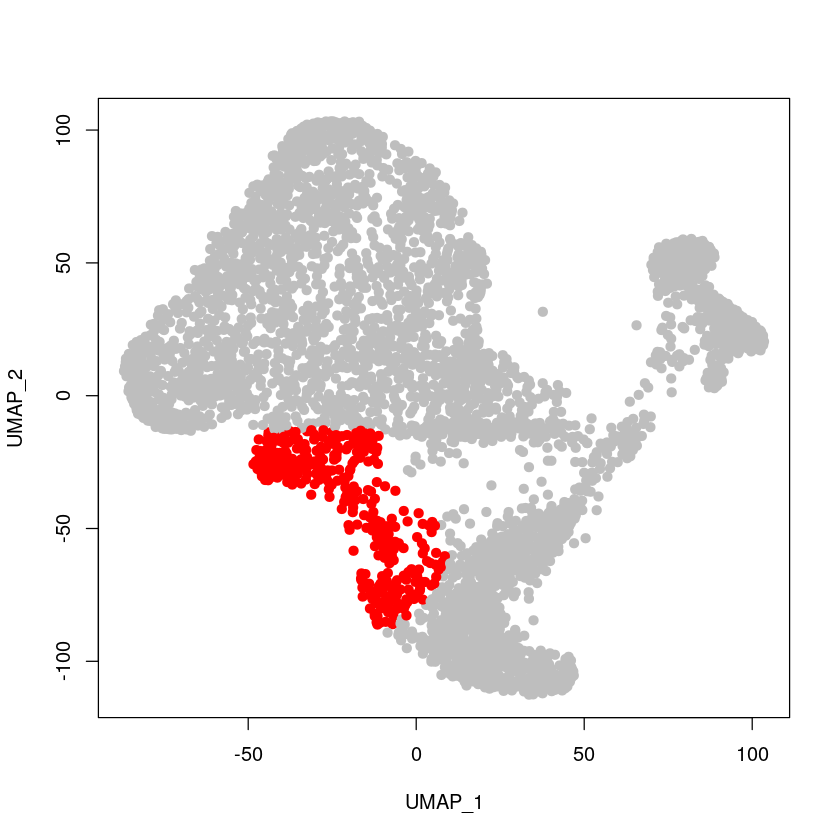

In [51]:
sel_ids = as.numeric(strsplit(selected, ',')[[1]])+1
cat(paste(sel_ids, collapse=','), '')
plot(adrenal_medulla$SR@reductions$umap@cell.embeddings[,1],
     adrenal_medulla$SR@reductions$umap@cell.embeddings[,2],
     col = ifelse(1:ncol(adrenal_medulla$SR) %in% (sel_ids), 'red', 'gray'),
     xlab='UMAP_1', ylab='UMAP_2', pch=19
)

In [12]:
sel_ids_txt = '92,130,154,157,160,162,171,181,183,184,185,186,187,188,189,196,197,198,201,211,225,226,232,252,253,255,256,258,259,260,261,262,263,265,271,272,273,276,282,291,304,305,309,317,342,343,350,351,367,368,369,373,376,383,387,388,391,405,410,414,421,430,431,437,456,465,467,481,494,507,517,520,528,541,542,554,560,567,581,582,583,585,591,595,597,598,599,609,611,614,617,621,628,630,639,641,644,659,664,667,671,676,680,690,691,694,697,700,712,725,726,727,732,748,751,760,767,774,782,786,819,821,837,839,845,847,872,873,921,1030,1087,1139,1165,1189,1192,1195,1216,1235,1240,1242,1261,1262,1268,1275,1337,1365,1381,1498,1502,1548,1582,1608,1631,1660,1684,1687,1713,1766,1768,1815,1825,1830,1838,1914,1938,1951,1975,1995,2011,2064,2071,2093,2123,2131,2205,2224,2252,2272,2289,2318,2337,2355,2391,2415,2454,2459,2498,2500,2515,2518,2523,2537,2544,2548,2558,2564,2570,2572,2573,2574,2576,2578,2583,2587,2596,2600,2607,2613,2621,2631,2633,2634,2635,2639,2643,2651,2663,2667,2670,2688,2690,2696,2701,2706,2712,2717,2719,2722,2735,2743,2753,2763,2790,2794,2795,2797,2804,2808,2819,2827,2844,2848,2851,2864,2866,2867,2876,2881,2882,2888,2903,2905,2915,2924,2926,2927,2933,2946,2947,2959,2961,2965,2966,2974,2980,2983,2989,2990,2991,3002,3013,3016,3021,3022,3027,3028,3037,3038,3062,3067,3071,3073,3080,3082,3083,3085,3091,3098,3112,3121,3123,3140,3143,3145,3154,3156,3157,3158,3169,3179,3181,3182,3183,3186,3187,3191,3196,3200,3212,3233,3236,3240,3241,3248,3252,3258,3265,3277,3283,3292,3294,3297,3311,3313,3315,3316,3320,3321,3324,3329,3337,3355,3357,3358,3359,3362,3364,3365,3371,3375,3379,3381,3398,3399,3400,3401,3406,3407,3422,3423,3424,3427,3429,3432,3450,3460,3485,3556,3611,3619,3630,3709,3722,3723,3747,3748,3757,3760,3763,3770,3771,3792,3793,3795,3797,3818,3845,3858 '

sel_ids = as.numeric(strsplit(sel_ids_txt, ',')[[1]])
sel_ids

[1]   92  130  154  157  160  162  171  181  183  184  185  186  187  188  189
 [16]  196  197  198  201  211  225  226  232  252  253  255  256  258  259  260
 [31]  261  262  263  265  271  272  273  276  282  291  304  305  309  317  342
 [46]  343  350  351  367  368  369  373  376  383  387  388  391  405  410  414
 [61]  421  430  431  437  456  465  467  481  494  507  517  520  528  541  542
 [76]  554  560  567  581  582  583  585  591  595  597  598  599  609  611  614
 [91]  617  621  628  630  639  641  644  659  664  667  671  676  680  690  691
[106]  694  697  700  712  725  726  727  732  748  751  760  767  774  782  786
[121]  819  821  837  839  845  847  872  873  921 1030 1087 1139 1165 1189 1192
[136] 1195 1216 1235 1240 1242 1261 1262 1268 1275 1337 1365 1381 1498 1502 1548
[151] 1582 1608 1631 1660 1684 1687 1713 1766 1768 1815 1825 1830 1838 1914 1938
[166] 1951 1975 1995 2011 2064 2071 2093 2123 2131 2205 2224 2252 2272 2289 2318
[181] 2337 2355 2391 2415 2454 2459 2498 2500 2515 2518 2523 2537 2544 2548 2558
[196] 2564 2570 2572 2573 2574 2576 2578 2583 2587 2596 2600 2607 2613 2621 2631
[211] 2633 2634 2635 2639 2643 2651 2663 2667 2670 2688 2690 2696 2701 2706 2712
[226] 2717 2719 2722 2735 2743 2753 2763 2790 2794 2795 2797 2804 2808 2819 2827
[241] 2844 2848 2851 2864 2866 2867 2876 2881 2882 2888 2903 2905 2915 2924 2926
[256] 2927 2933 2946 2947 2959 2961 2965 2966 2974 2980 2983 2989 2990 2991 3002
[271] 3013 3016 3021 3022 3027 3028 3037 3038 3062 3067 3071 3073 3080 3082 3083
[286] 3085 3091 3098 3112 3121 3123 3140 3143 3145 3154 3156 3157 3158 3169 3179
[301] 3181 3182 3183 3186 3187 3191 3196 3200 3212 3233 3236 3240 3241 3248 3252
[316] 3258 3265 3277 3283 3292 3294 3297 3311 3313 3315 3316 3320 3321 3324 3329
[331] 3337 3355 3357 3358 3359 3362 3364 3365 3371 3375 3379 3381 3398 3399 3400
[346] 3401 3406 3407 3422 3423 3424 3427 3429 3432 3450 3460 3485 3556 3611 3619
[361] 3630 3709 3722 3723 3747 3748 3757 3760 3763 3770 3771 3792 3793 3795 3797
[376] 3818 3845 3858

In [75]:

pdf('figures/fig2_pk_take2_selbridge/selection_bridge2.pdf')
plot(adrenal_medulla$SR@reductions$umap@cell.embeddings[,1],
     adrenal_medulla$SR@reductions$umap@cell.embeddings[,2],
     col = ifelse(1:ncol(adrenal_medulla$SR) %in% (sel_ids), 'red', 'gray'),
     xlab='UMAP_1', ylab='UMAP_2', pch=19
)
dev.off()

png 
  2

In [48]:
head(adrenal_medulla$SR@reductions$umap@cell.embeddings)

UMAP_1    UMAP_2    
R39_w9.5_AAACCCAAGTATGGCG-1 34.802112 -112.46328
R30_w8.5_ATGCCTCTCGCATAGT-1 13.347243 -100.16087
R30_w8.5_CACTAAGTCATCGCAA-1  1.605501  -92.77246
R30_w8.5_CAGCCAGTCATCACAG-1 -3.434032  -86.17790
R30_w8.5_CCCTGATAGCAAGGAA-1 -1.258604  -88.78788
R30_w8.5_CGTGATATCGCCCAGA-1 35.580420 -109.65973

In [34]:
head(sel_ids)

[1] "161" "170" "183" "184" "195" "196"

In [14]:
adrenal_medulla_bridge2 = new.env()
adrenal_medulla_bridge2$SR = adrenal_medulla$SR[,sel_ids]

# Fit trajectories, plot heatmap of genes that change along trajectories

In [166]:
source('../src/bridge_heatmap.R')
suppressWarnings({
    cds = seurat2monocle(adrenal_medulla_bridge2$SR, fix_partitions=T)
})


Saving 6.67 x 6.67 in image



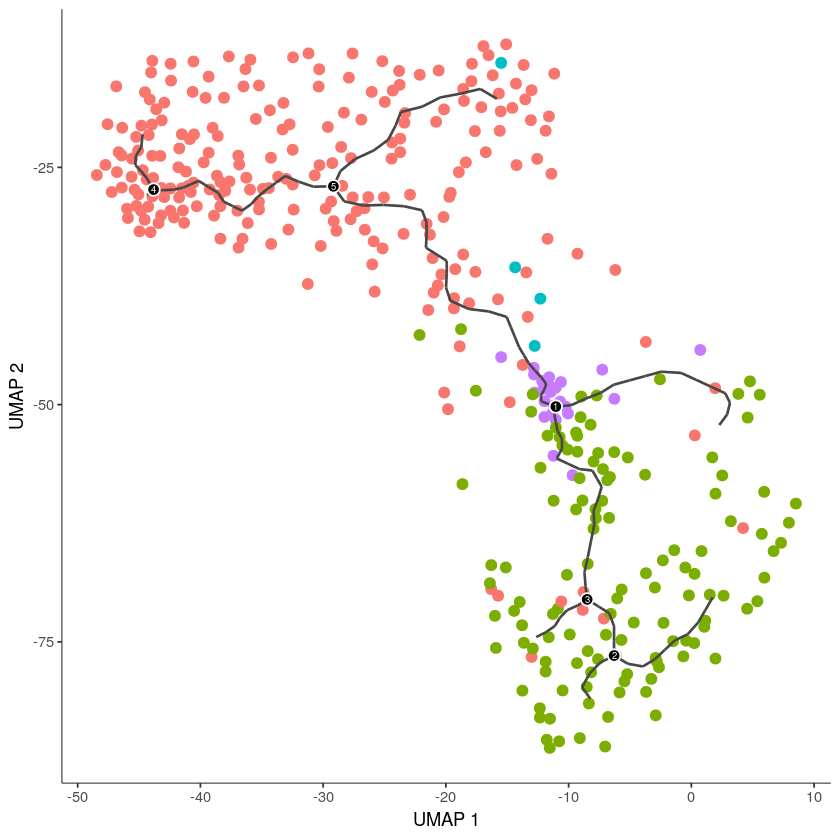

In [59]:
plot_cells(cds,
           color_cells_by = "seurat_cluster",
           label_groups_by_cluster=FALSE,
           label_leaves=FALSE,
           label_branch_points=T,
          cell_size = 2,
          label_cell_groups=F)+NoLegend()
dir.create('figures/fig2_pk_take2_selbridge/')
ggsave('figures/fig2_pk_take2_selbridge/tmp.trajectory.SCP2symp.pdf')

Warning message in subgraph(cds@principal_graph$UMAP, all_simple_paths(cds@principal_graph$UMAP, :
“At structural_properties.c:1984 :igraph_subgraph is deprecated from igraph 0.6, use igraph_induced_subgraph instead”


[1] "figures/fig2_pk_take2_selbridge/heatmap.withSTAR.SCP2symp.2.pdf"


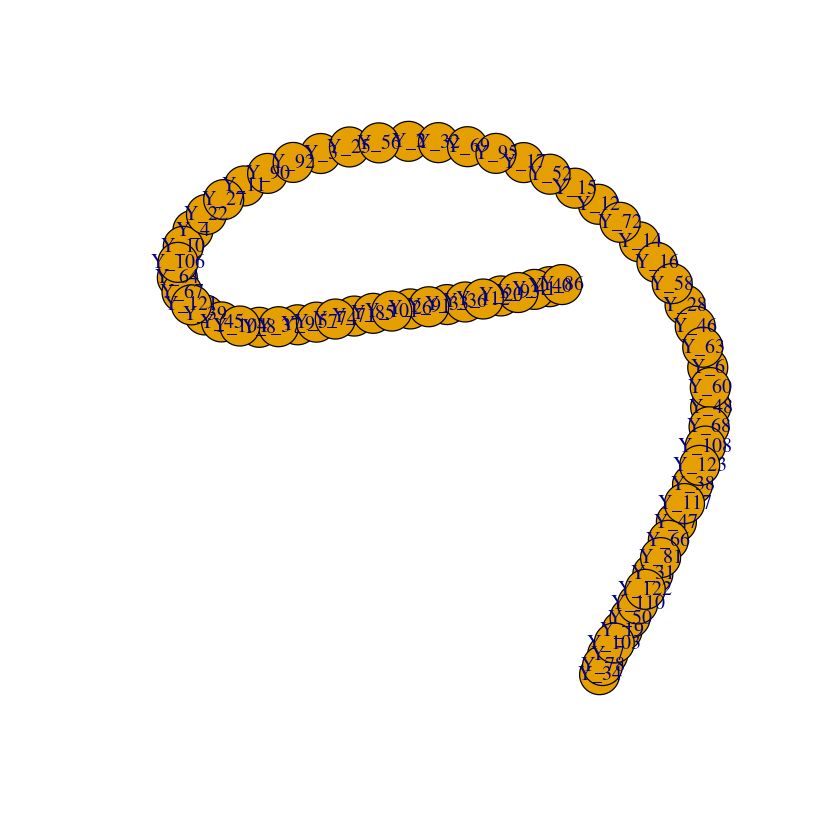

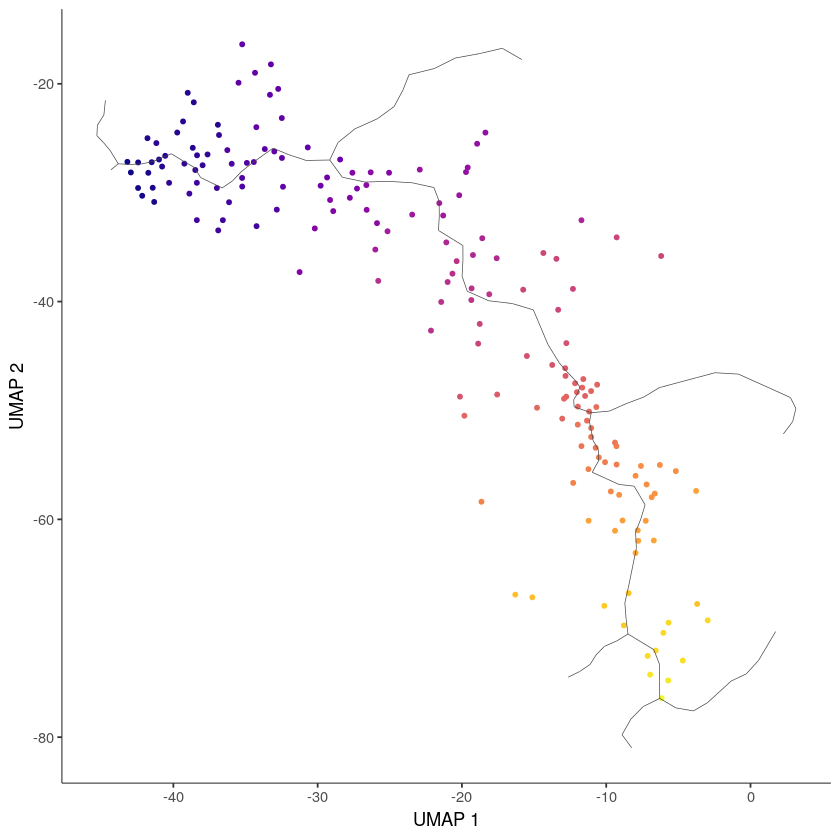

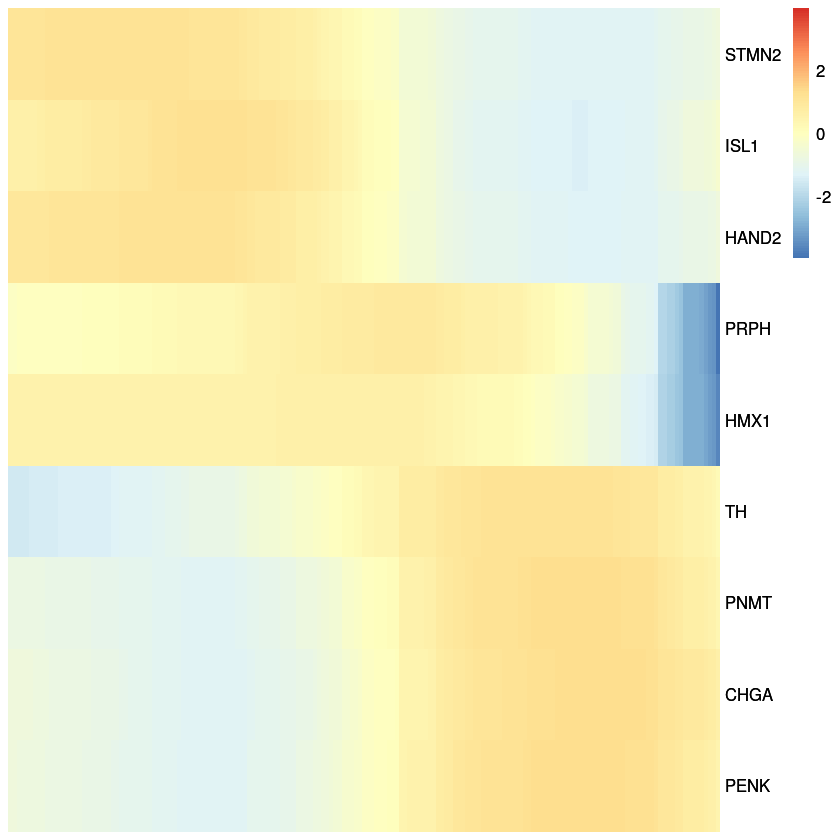

In [77]:
pr_deg_ids = toupper(c(
    'Stmn2','Isl1','Hand2','Prph','Hmx1','Th','Pnmt','Chga','Penk' 
))

#pr_deg_ids = c('NGFR', 'SOX10', 'PLP1', 'FOXD3', 'S100B',  'ERBB3', 'PRPH', 'STMN2', 'TH', 'HAND2', 'ISL1',  'HMX1')
analyze_bridge(cds, 4, 2, pr_deg_ids, f_heatmap = 'figures/fig2_pk_take2_selbridge/heatmap.withSTAR.SCP2symp.2.pt5.pdf')

Warning message in subgraph(cds@principal_graph$UMAP, all_simple_paths(cds@principal_graph$UMAP, :
“At structural_properties.c:1984 :igraph_subgraph is deprecated from igraph 0.6, use igraph_induced_subgraph instead”


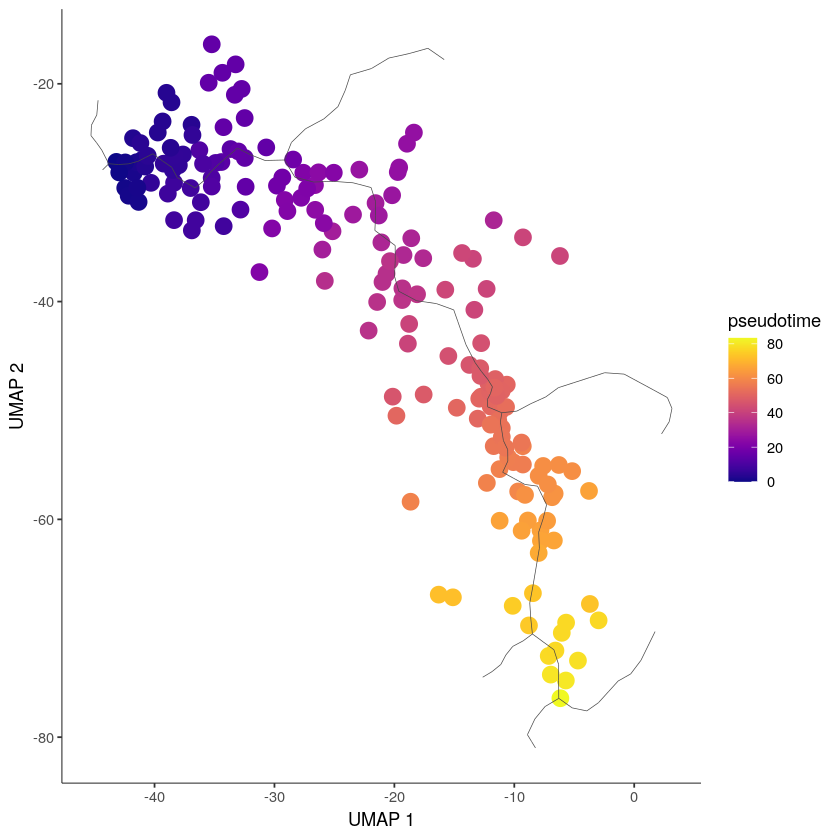

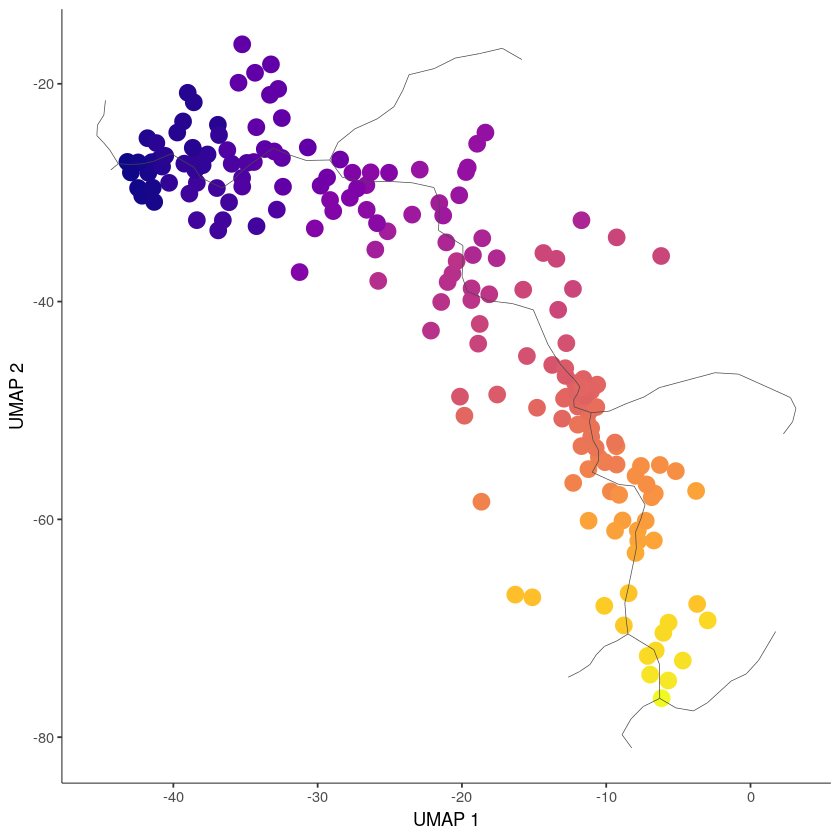

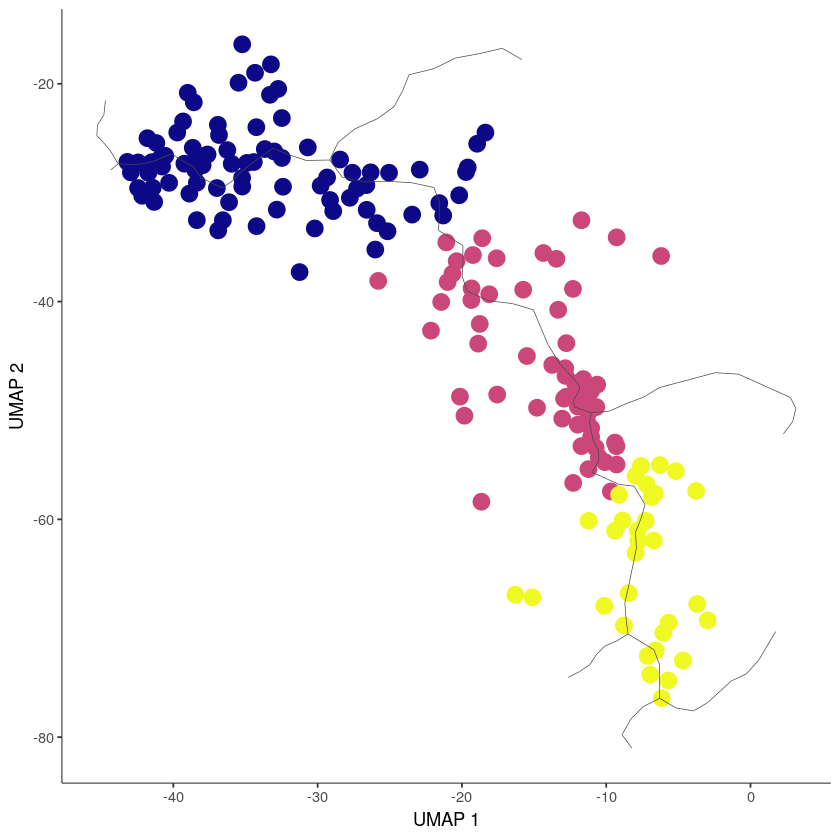

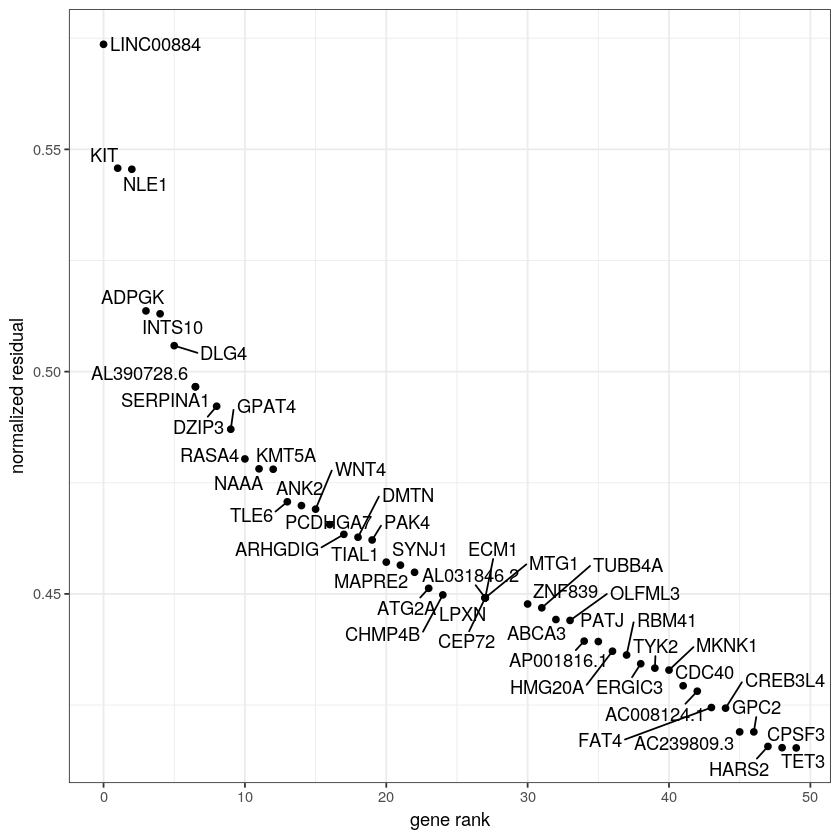

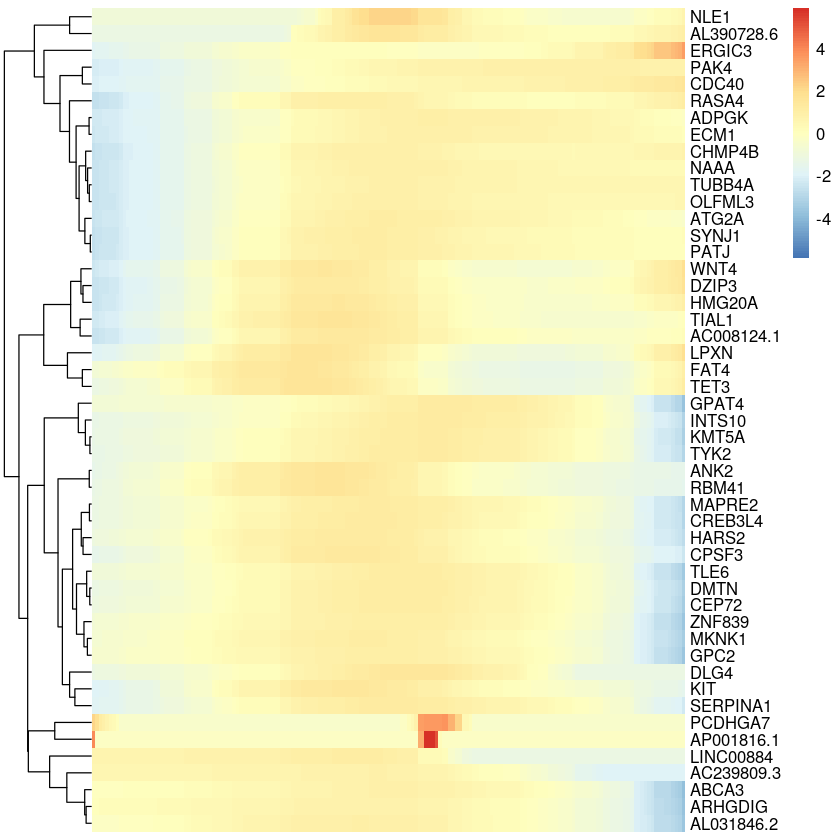

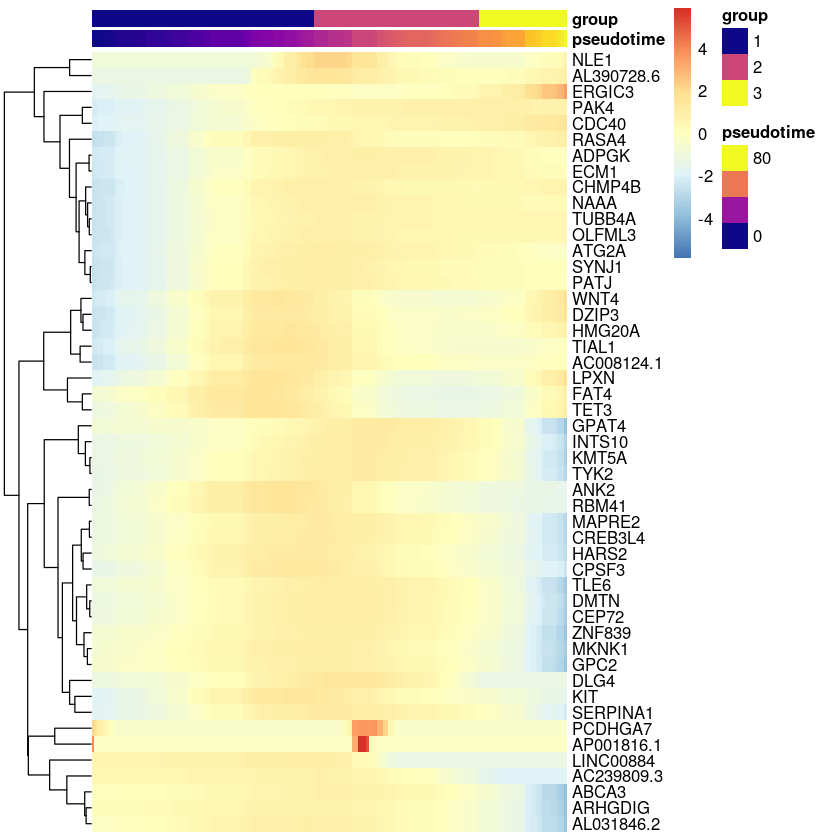

In [167]:
source('../src/bridge_heatmap.R')

pl = bridge_genes(cds, 4, 2, pst_breaks = c(30,60), pr_deg_ids=c(), prefix='figures/fig2_pk_take2_selbridge/nonlin.sympathoblasts_chromaffin.pt3.', pt.size=3)

In [28]:
source('../src/bridge_heatmap.R')
suppressWarnings({
    cds = seurat2monocle(adrenal_medulla$SR, fix_partitions=T)
})

  |======================================================================| 100%


Warning message in dir.create("figures/fig2_pk_take2_fork/"):
“'figures/fig2_pk_take2_fork' already exists”
Saving 6.67 x 6.67 in image



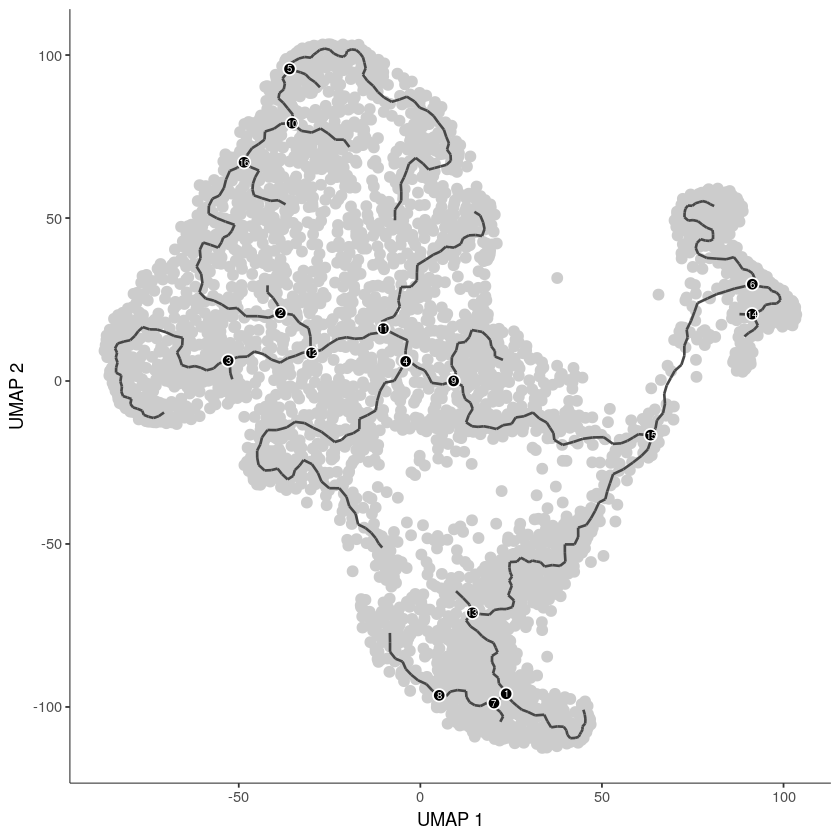

Warning message in dir.create("figures/fig2_pk_take2_fork/"):
“'figures/fig2_pk_take2_fork' already exists”
Saving 6.67 x 6.67 in image



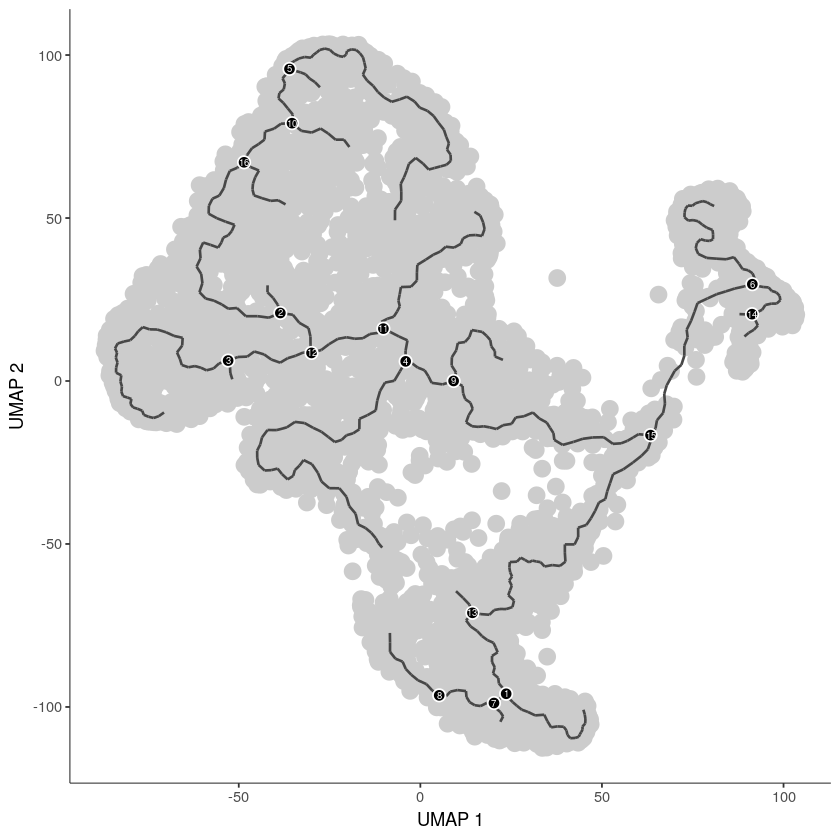

In [38]:
plot_cells(cds,
           color_cells_by = "seurat_cluster",
           label_groups_by_cluster=FALSE,
           label_leaves=FALSE,
           label_branch_points=T,
          cell_size = 2,
          label_cell_groups=F)+NoLegend()+scale_color_grey(start=0.8,end=0.8)
dir.create('figures/fig2_pk_take2_fork/')
ggsave('figures/fig2_pk_take2_fork/tmp.trajectory.gray.pdf')

plot_cells(cds,
           color_cells_by = "seurat_cluster",
           label_groups_by_cluster=FALSE,
           label_leaves=FALSE,
           label_branch_points=T,
          cell_size = 3,
          label_cell_groups=F)+NoLegend()+scale_color_grey(start=0.8,end=0.8)
dir.create('figures/fig2_pk_take2_fork/')
ggsave('figures/fig2_pk_take2_fork/tmp.trajectory.gray.pt3.pdf')

In [ ]:
plot_cells(cds,
           color_cells_by = "seurat_cluster",
           label_groups_by_cluster=FALSE,
           label_leaves=FALSE,
           label_branch_points=T,
          cell_size = 2,
          label_cell_groups=F)+NoLegend()
dir.create('figures/fig2_pk_take2_fork/')
ggsave('figures/fig2_pk_take2_fork/tmp.trajectory.SCP2symp.pdf')

Warning message in subgraph(cds@principal_graph$UMAP, all_simple_paths(cds@principal_graph$UMAP, :
“At structural_properties.c:1984 :igraph_subgraph is deprecated from igraph 0.6, use igraph_induced_subgraph instead”


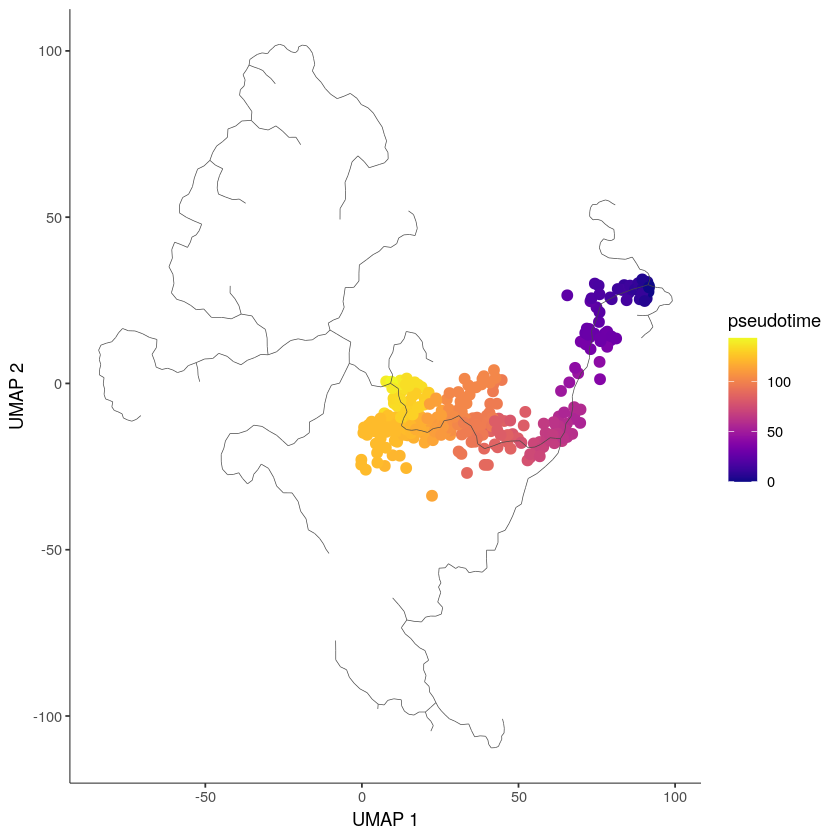

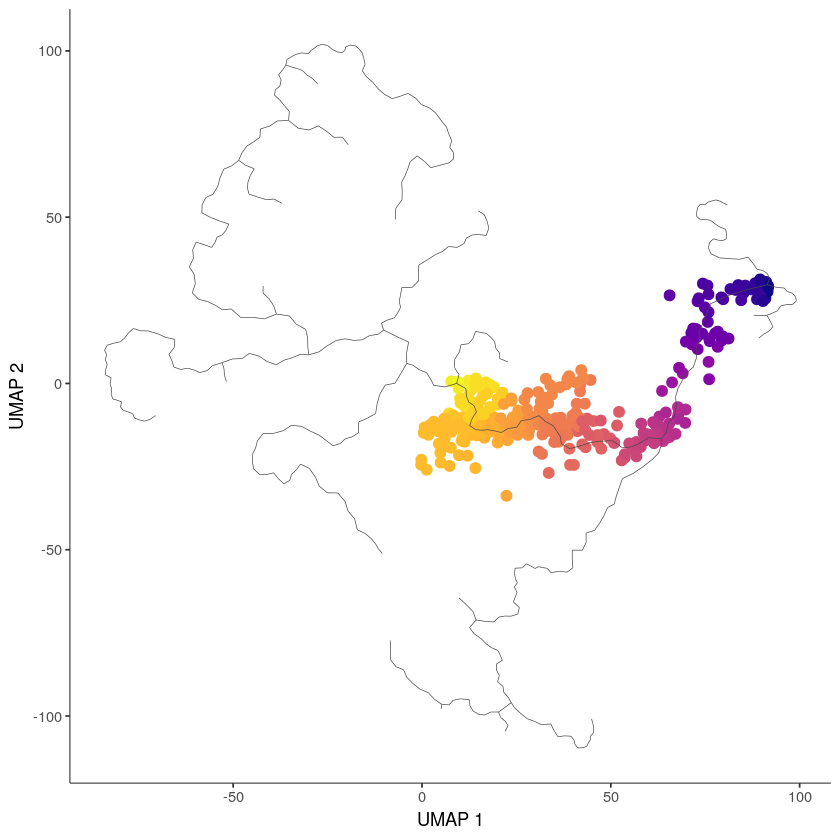

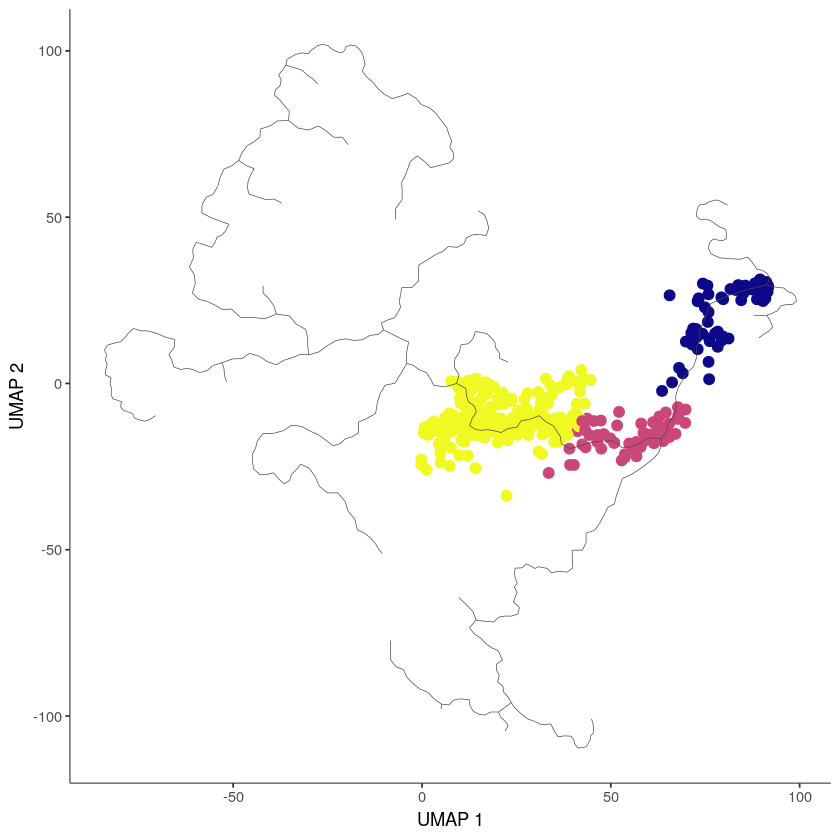

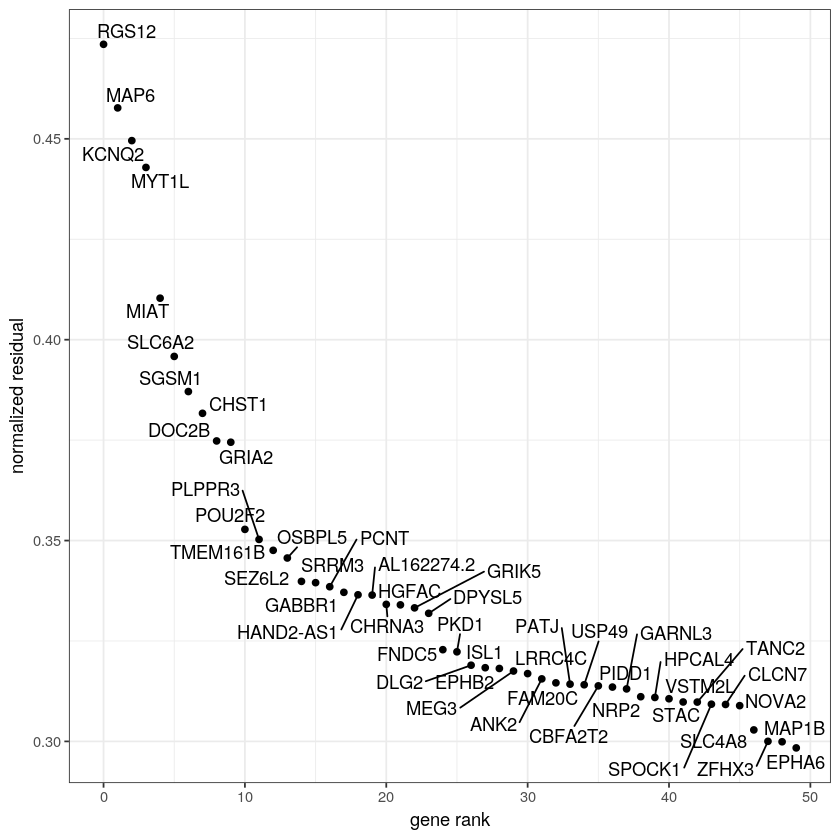

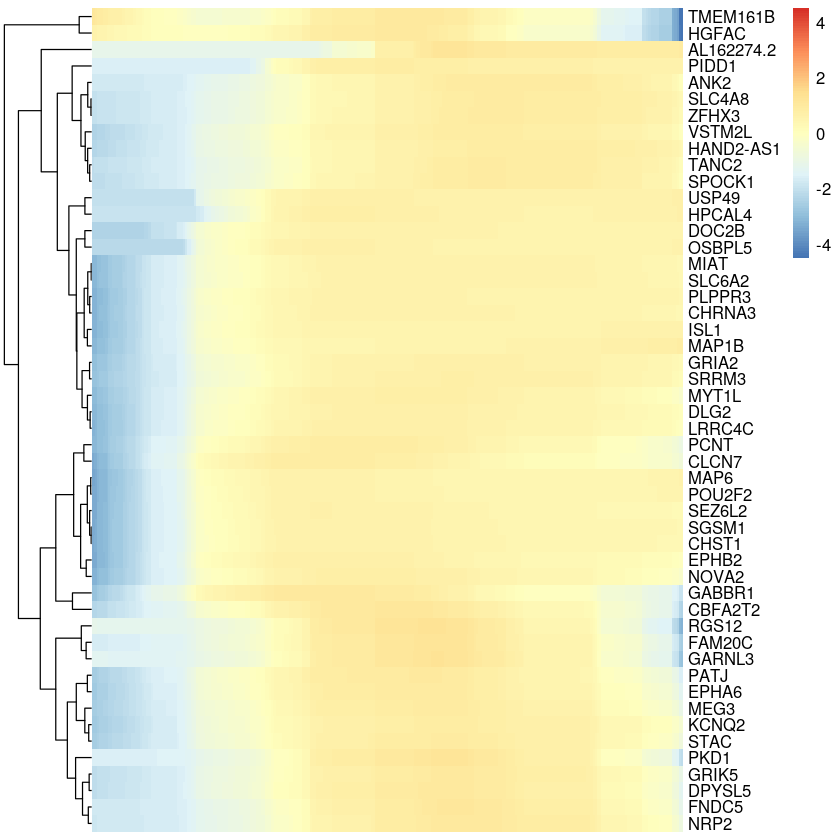

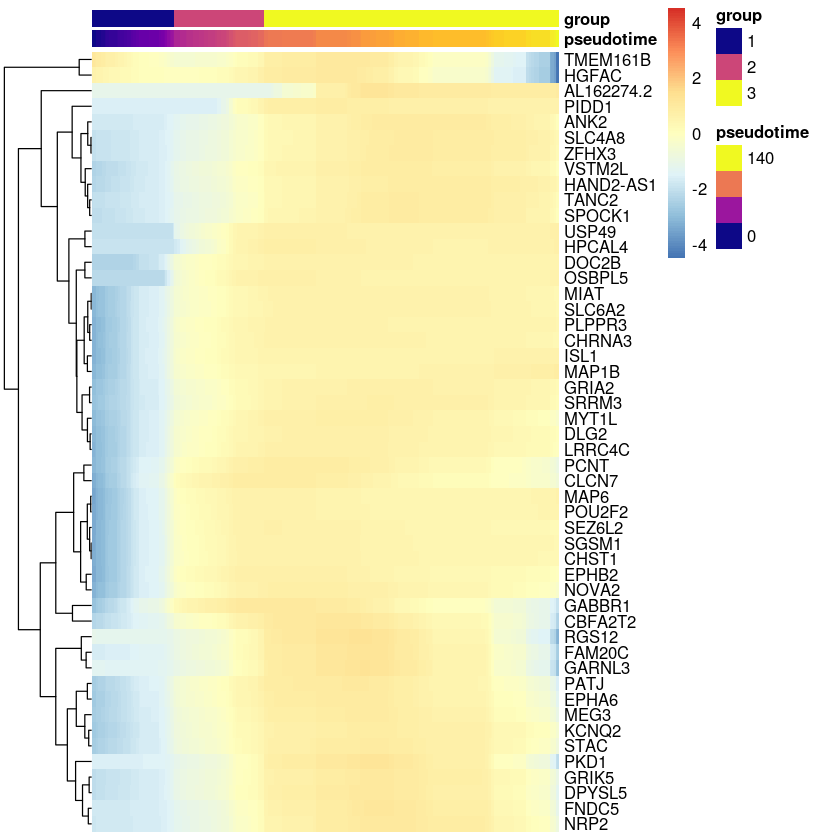

In [164]:
source('../src/bridge_heatmap.R')

pl = bridge_genes(cds, 6, 9, pst_breaks = c(50,90), pr_deg_ids=c(), prefix='figures/fig2_pk_take2_fork/nonlin.SCP_sympathoblast.pst50_90.pt2.', pt.size=2)

Warning message in subgraph(cds@principal_graph$UMAP, all_simple_paths(cds@principal_graph$UMAP, :
“At structural_properties.c:1984 :igraph_subgraph is deprecated from igraph 0.6, use igraph_induced_subgraph instead”


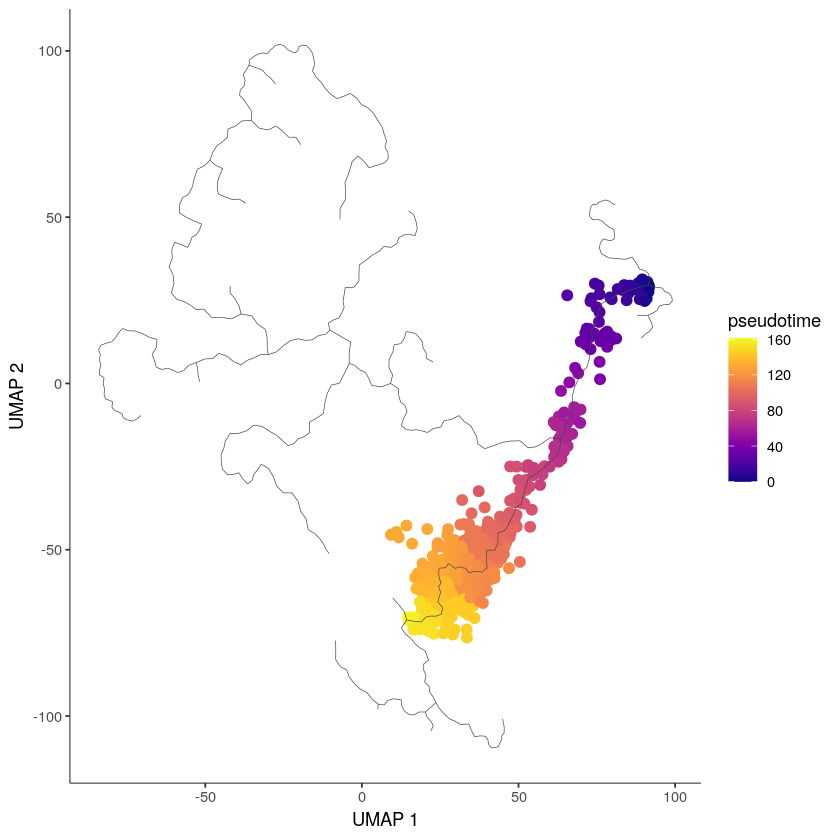

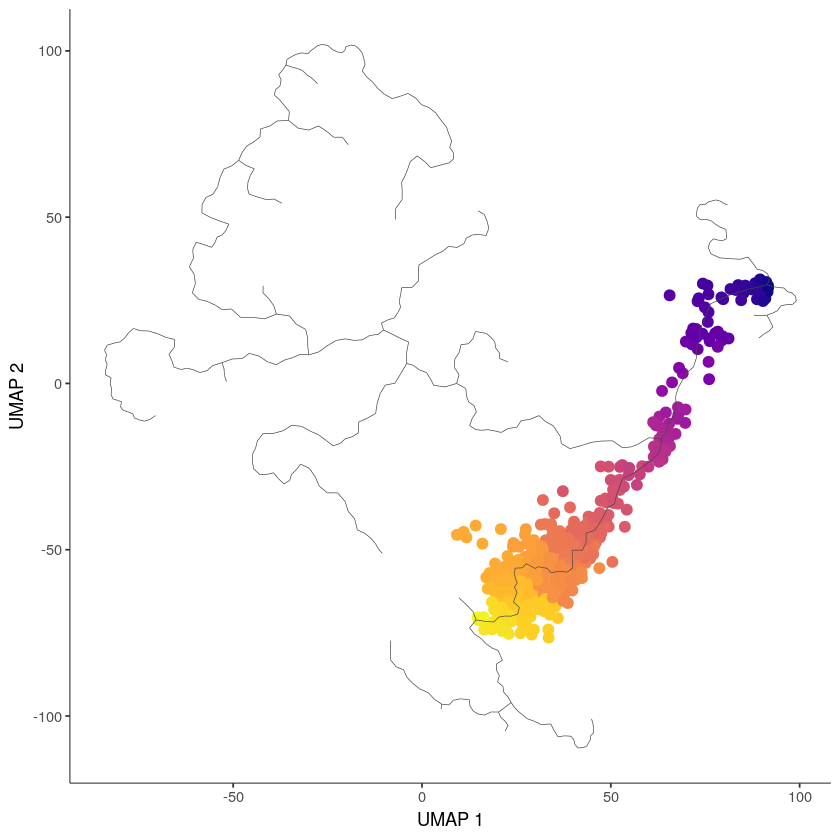

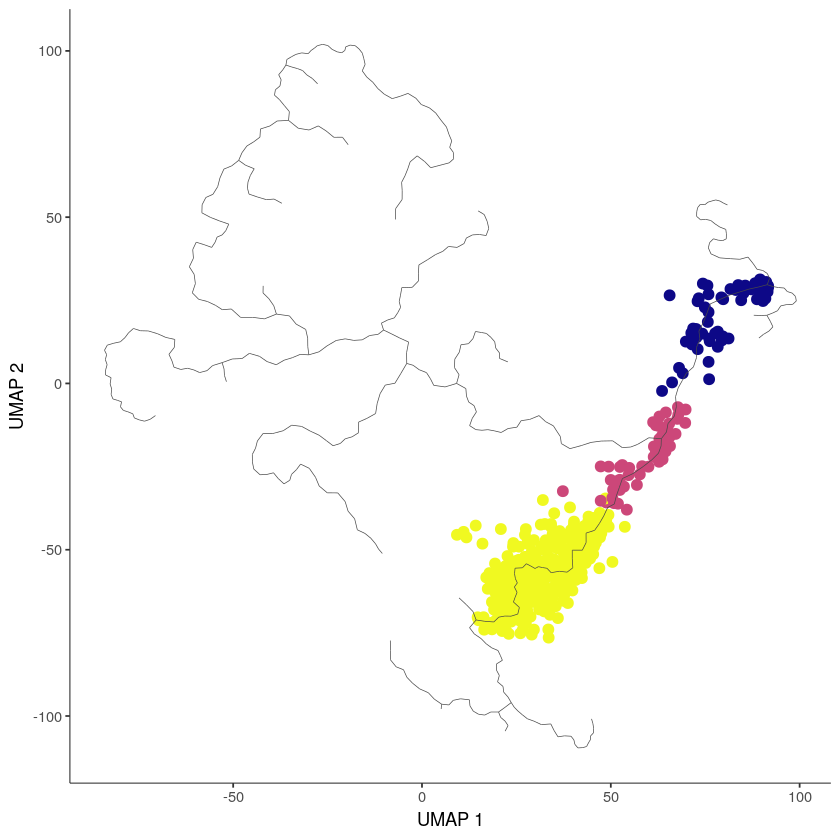

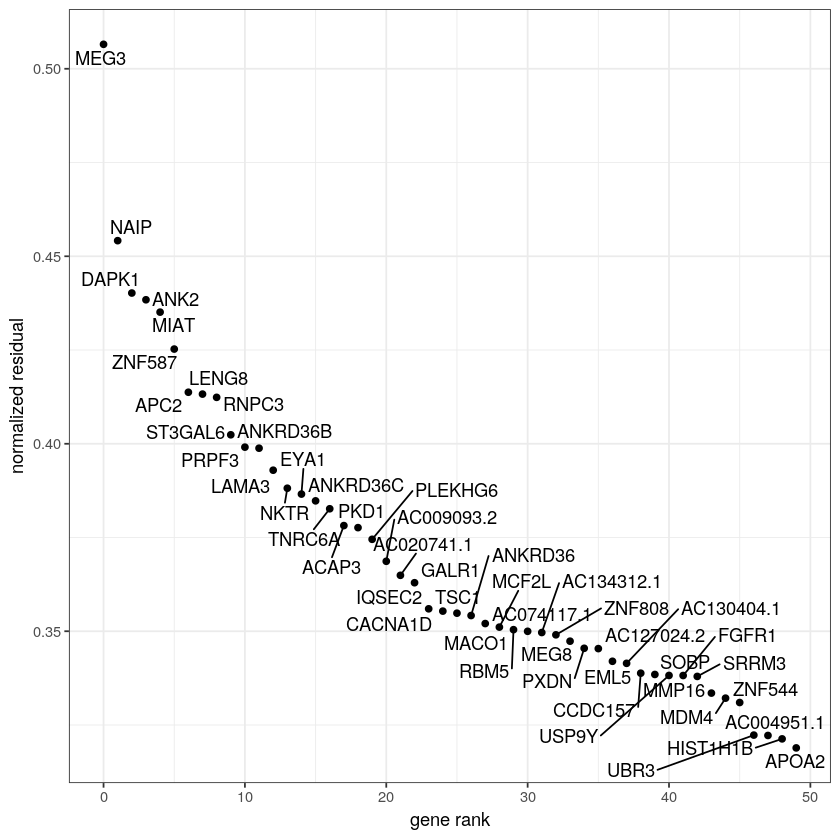

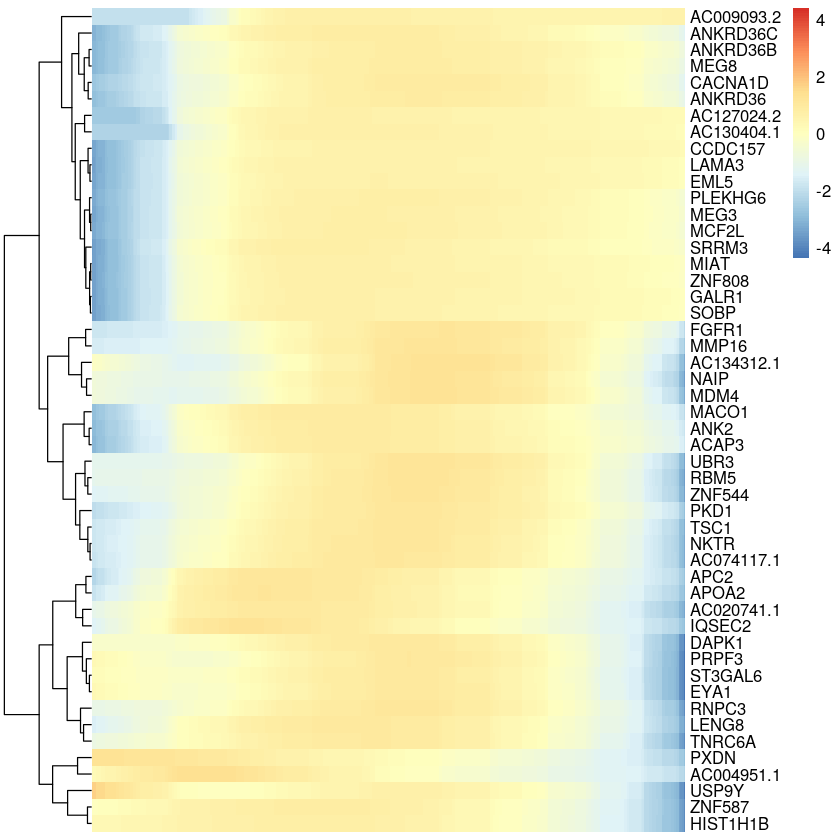

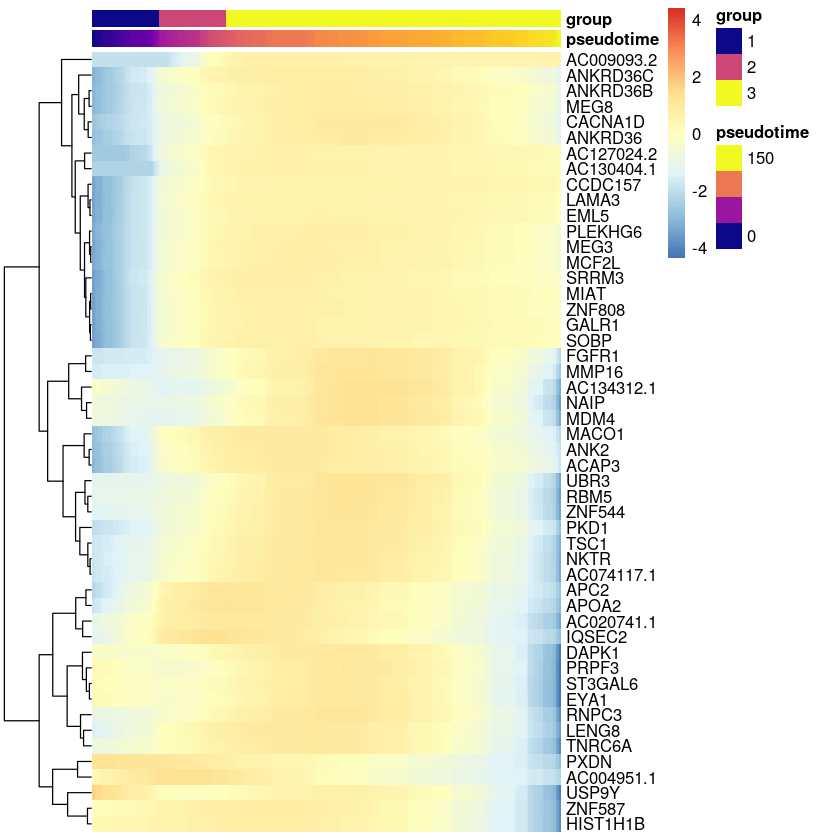

In [165]:
pl = bridge_genes(cds, 6, 13, pst_breaks = c(50,90), pr_deg_ids=c(), prefix='figures/fig2_pk_take2_fork/nonlin.SCP_chromaffin.pst50_90.pt2.', pt.size=2)

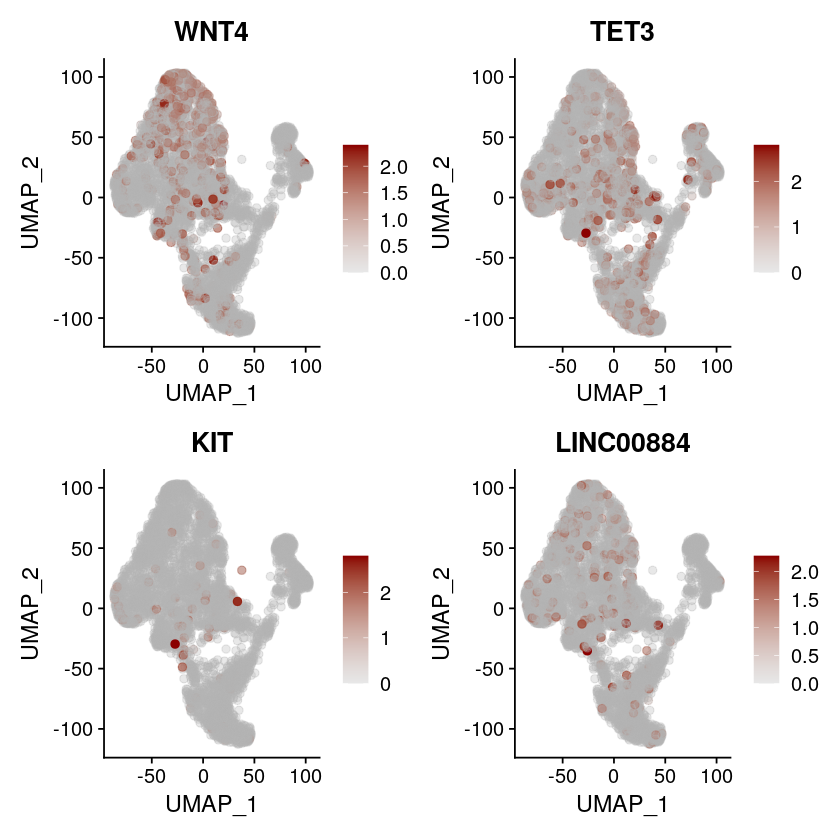

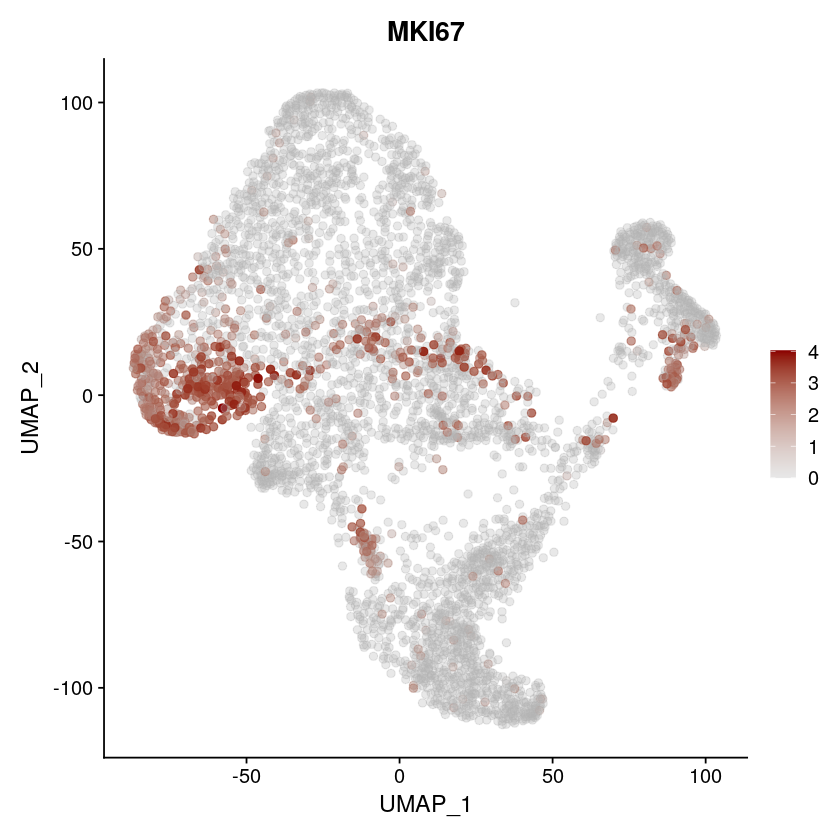

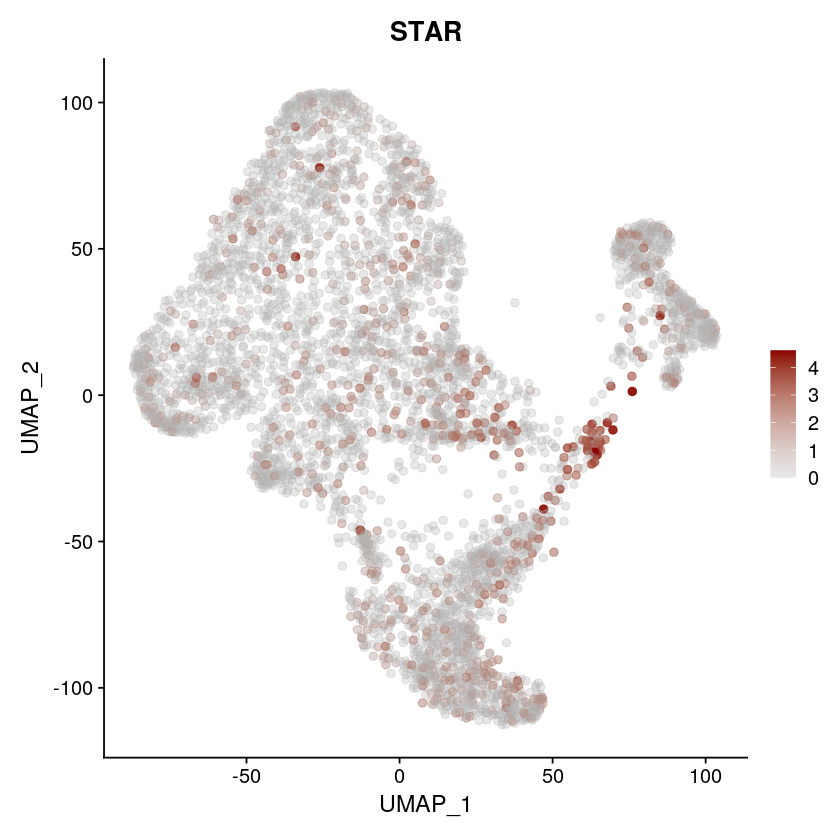

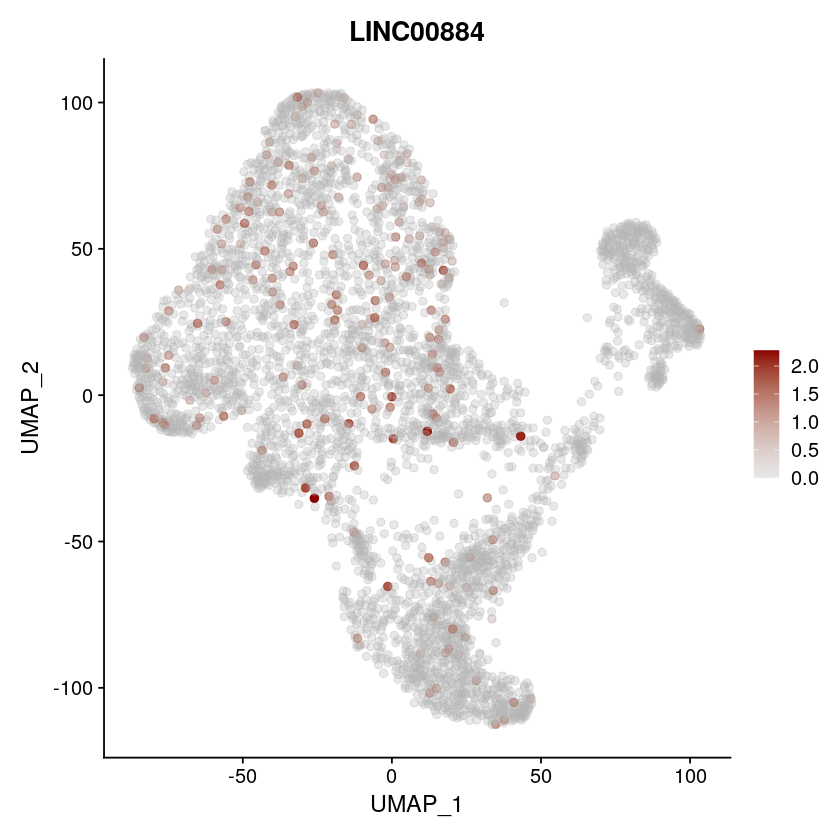

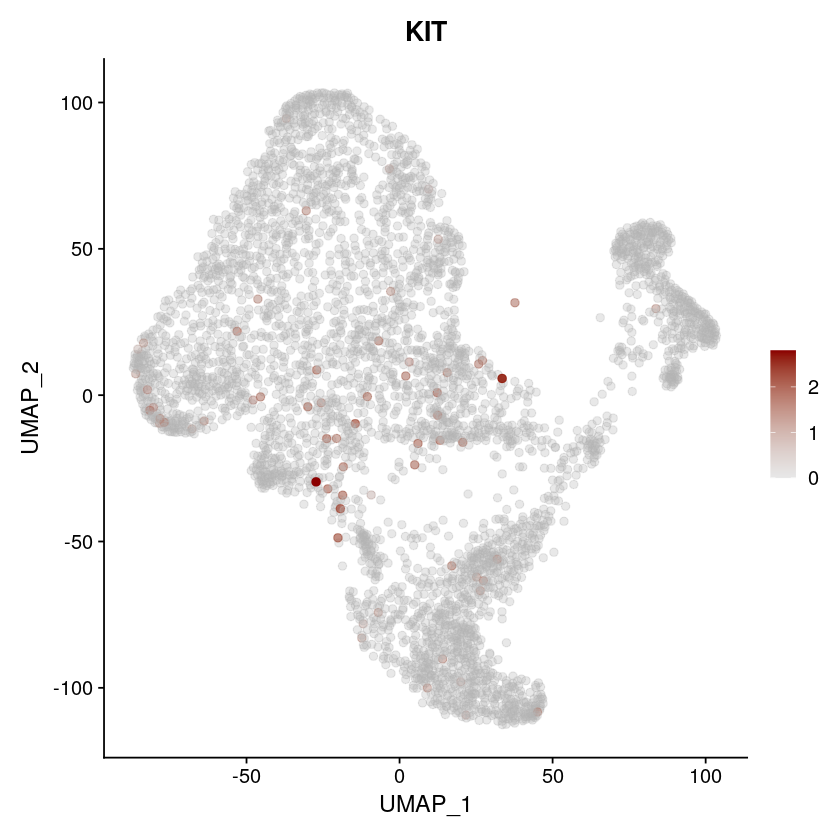

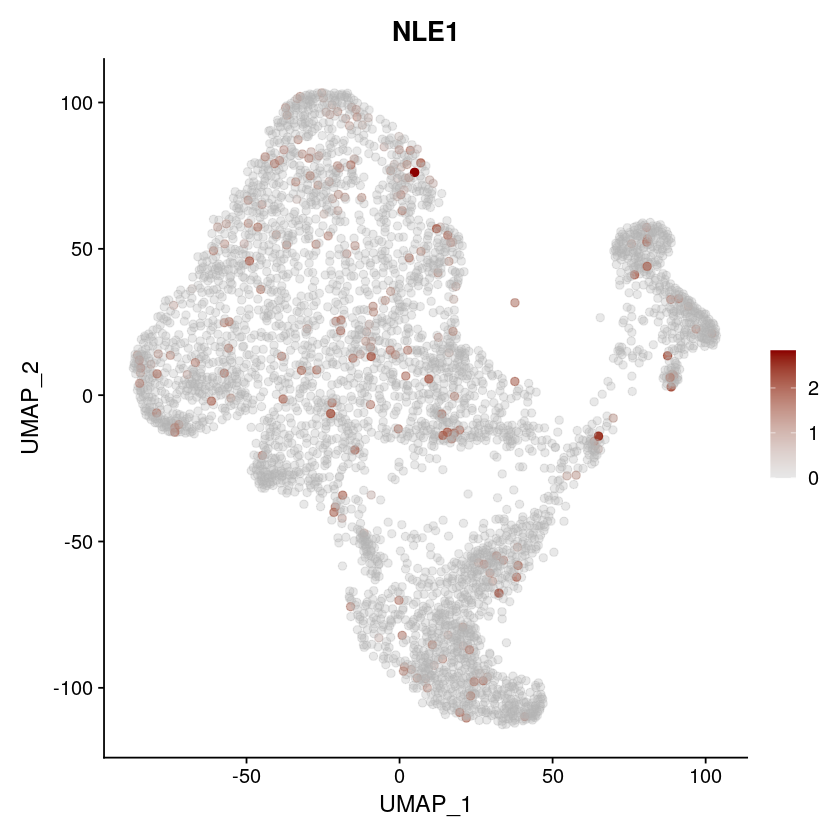

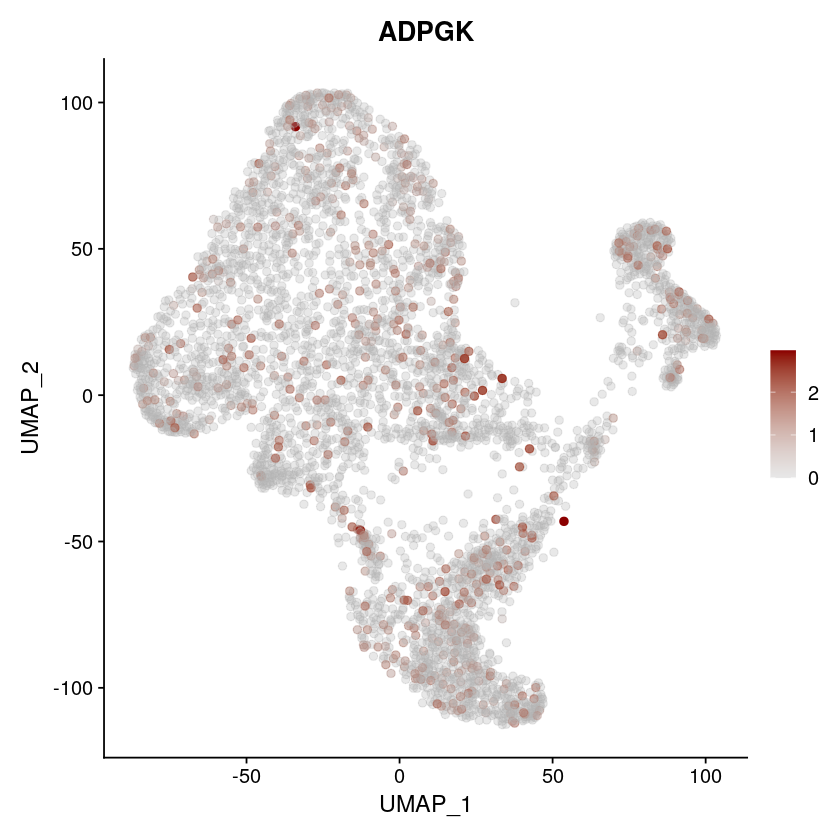

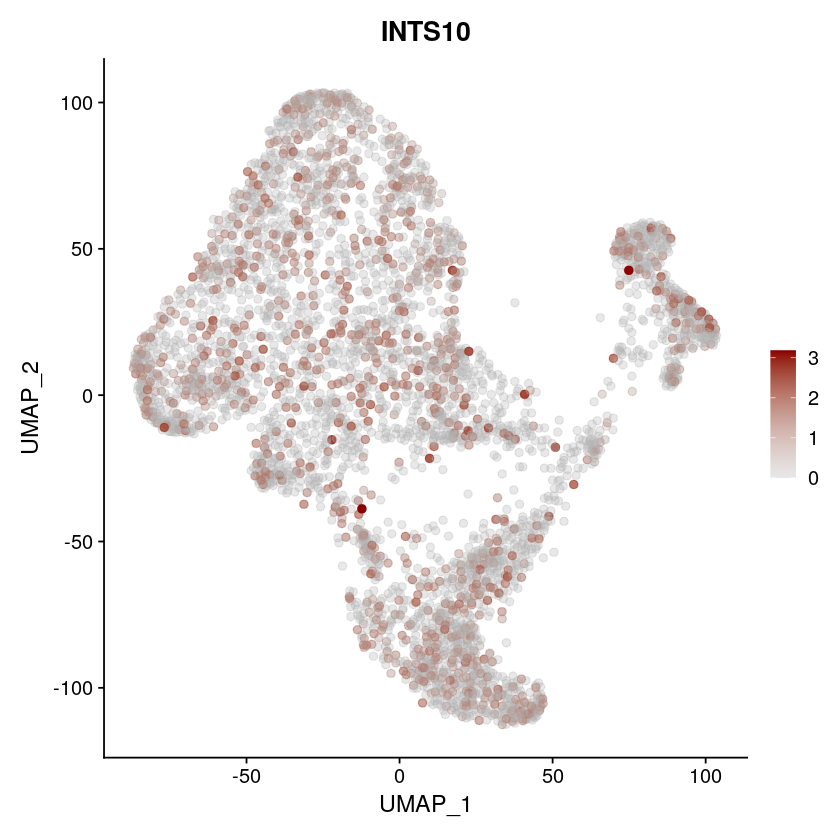

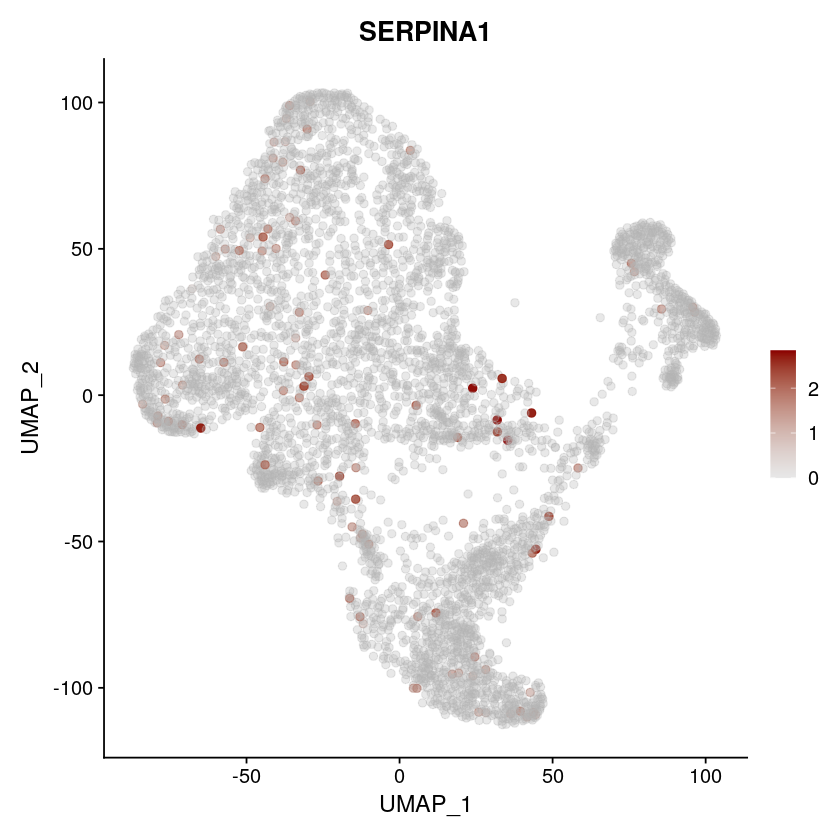

In [70]:
FeaturePlot(adrenal_medulla$SR, c('WNT4', 'TET3', 'KIT', 'LINC00884'), reduction = 'umap', pt.size = 2, cols = c(rgb(0.7,0.7,0.7, alpha=0.3), "darkred"))

FeaturePlot(adrenal_medulla$SR, c('MKI67'), reduction = 'umap', pt.size = 2, cols = c(rgb(0.7,0.7,0.7, alpha=0.3), "darkred"))
FeaturePlot(adrenal_medulla$SR, c('STAR'), reduction = 'umap', pt.size = 2, cols = c(rgb(0.7,0.7,0.7, alpha=0.3), "darkred"))

nonlin_genes = c('LINC00884', 'KIT', 'NLE1', 'ADPGK', 'INTS10', 'SERPINA1')
for(gene in nonlin_genes){
    plot(
        FeaturePlot(adrenal_medulla$SR, gene, reduction = 'umap', pt.size = 2, cols = c(rgb(0.7,0.7,0.7, alpha=0.3), "darkred"))
    )
}

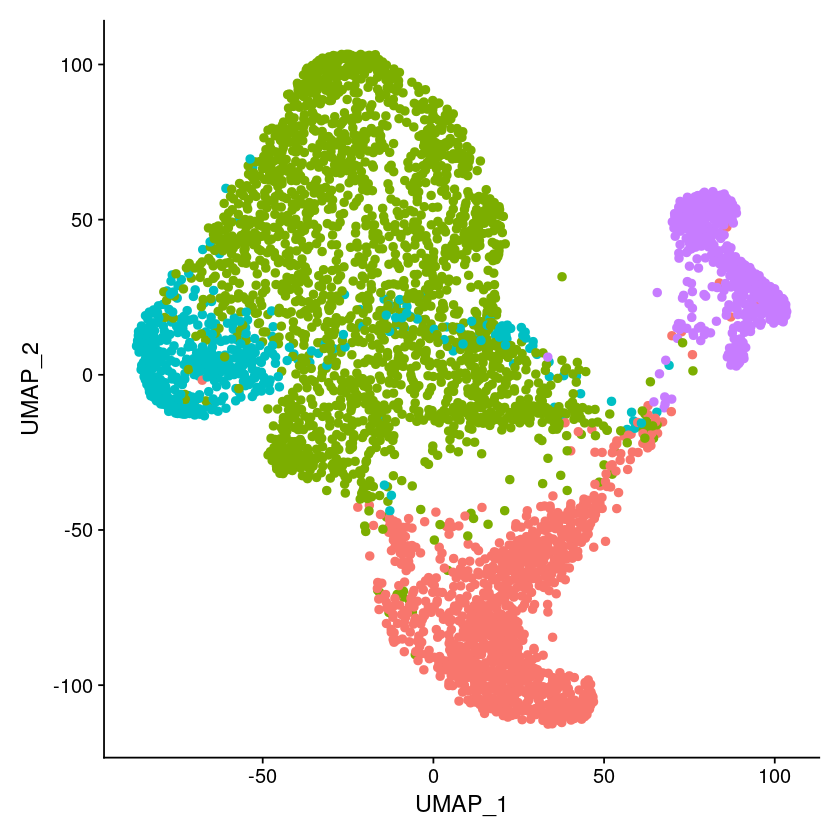

In [71]:
Idents(adrenal_medulla$SR) = 'fate'
DimPlot(adrenal_medulla$SR, reduction = 'umap', pt.size = 2) + NoLegend()
ggsave('figures/fig2_pk_take2_selbridge/001b.adrenal_medulla.clusters_labelled.png', width=5, height=5, dpi=320)

In [74]:
#export metadata for velocity plots

write.csv(adrenal_medulla$SR@meta.data, file='../data/embeddings/medulla_pk2.metadata.csv')

In [78]:
adrenal_medulla$SR <- CellCycleScoring(adrenal_medulla$SR, s.features = cc.genes$s.genes, g2m.features = cc.genes$g2m.genes, set.ident = TRUE)

Warning message:
“The following features are not present in the object: MLF1IP, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: FAM64A, HN1, not searching for symbol synonyms”


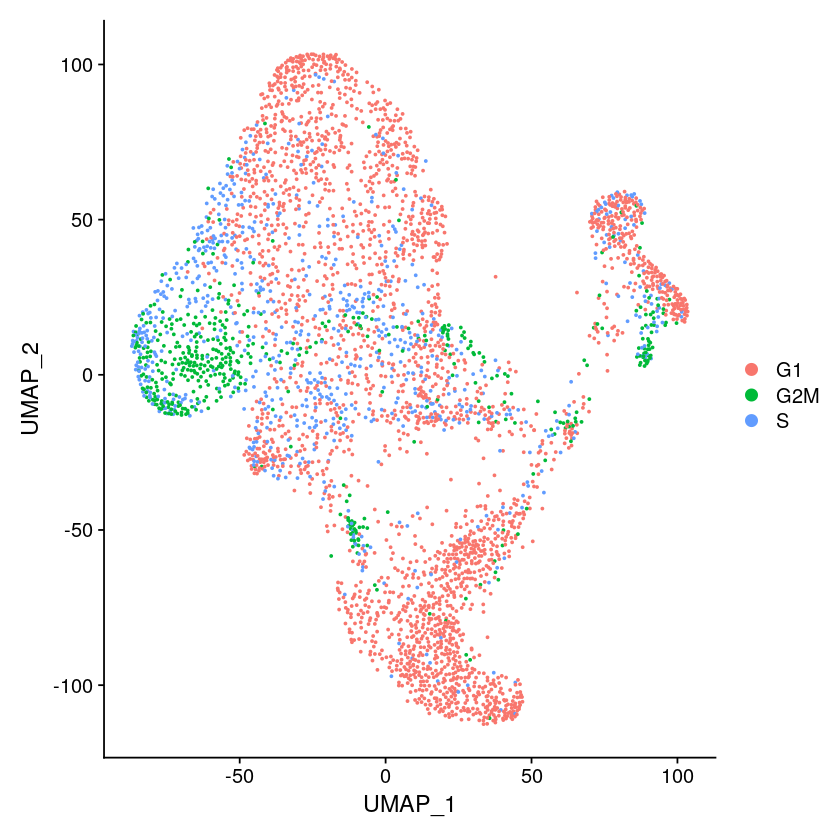

In [82]:
# color by cell cycle

DimPlot(adrenal_medulla$SR, group.by = 'Phase', pt.size = 2)
ggsave('figures/fig2_pk_take2_selbridge/005.adrenal_medulla.cellcycle_legend.png', width=5, height=5, dpi=320)
DimPlot(adrenal_medulla$SR, group.by = 'Phase', pt.size = 2) + NoLegend()
ggsave('figures/fig2_pk_take2_selbridge/005.adrenal_medulla.cellcycle.png', width=5, height=5, dpi=320)

# Embedding colored by sample

In [ ]:
vcols = c('#15983DFF','#16A08CFF','#0C5BB0FF','#A1C720FF','#FA6B09FF','#149BEDFF','#EC579AFF','#EE0011FF','#FEC10BFF')
#inspired by yarrr::piratepal("basel")

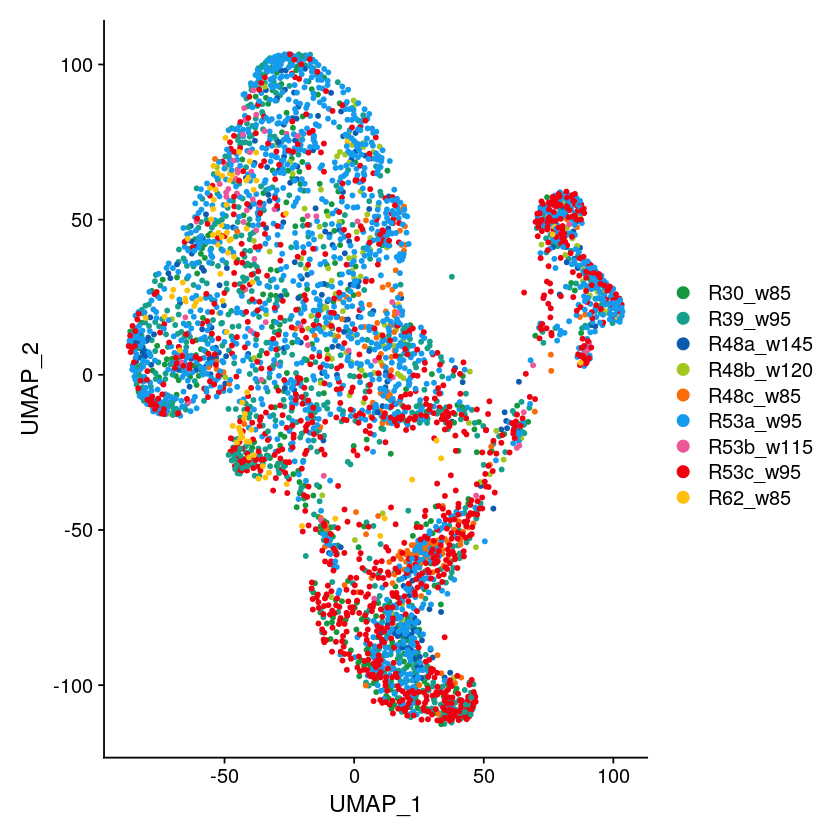

In [9]:
vcols = yarrr::piratepal("basel")[1:length(unique(adrenal_medulla$SR@meta.data$orig.ident))]
names(vcols)=NULL
vcols = sample(vcols)
DimPlot(adrenal_medulla$SR, group.by = 'orig.ident', pt.size = 1)+
    scale_color_manual(values=vcols)


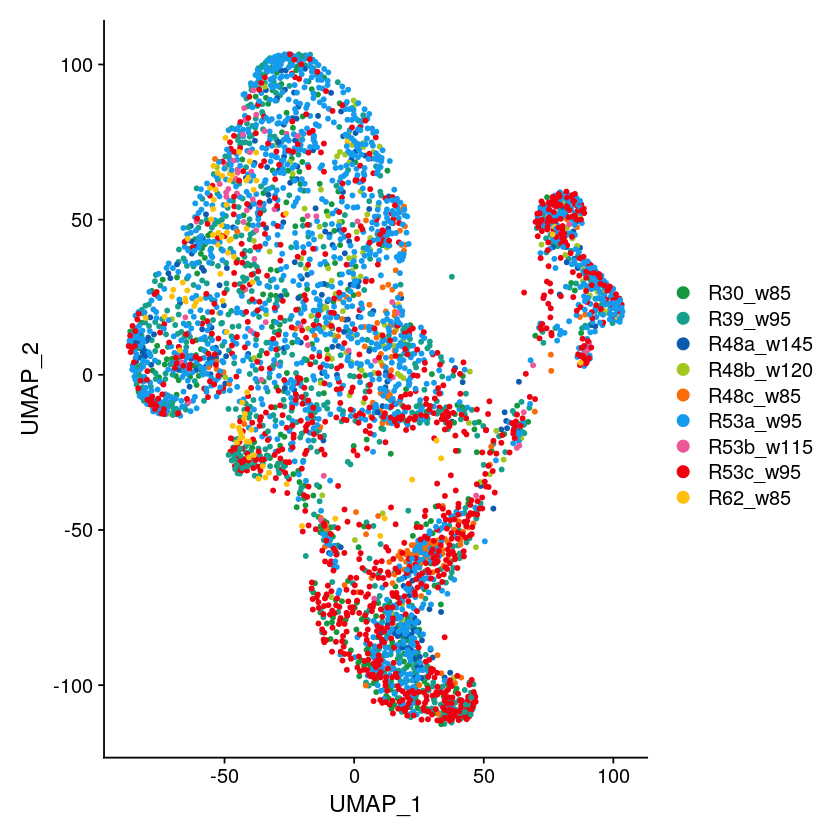

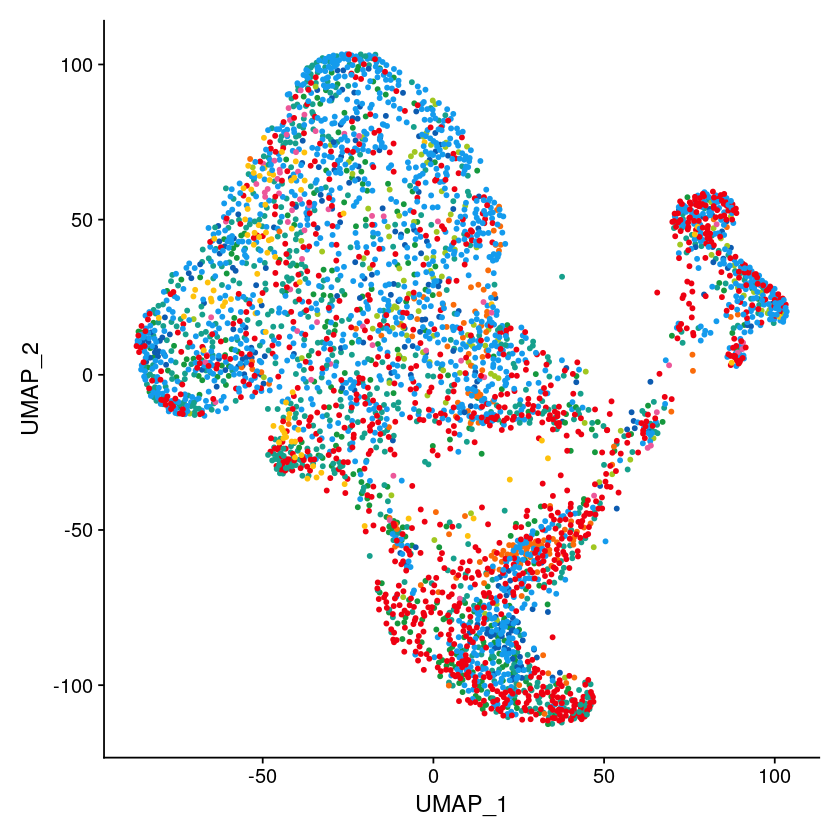

In [11]:
DimPlot(adrenal_medulla$SR, group.by = 'orig.ident', pt.size = 1)+
    scale_color_manual(values=vcols)
ggsave('figures/fig2_pk_take2_selbridge/005.adrenal_medulla.sample_legend.pt1.pal_basel.png', width=5, height=5, dpi=320)
DimPlot(adrenal_medulla$SR, group.by = 'orig.ident', pt.size = 1)+NoLegend()+scale_color_manual(values=vcols)
ggsave('figures/fig2_pk_take2_selbridge/005.adrenal_medulla.sample.pt1.pal_basel.png', width=5, height=5, dpi=320)


# Export embeddings per timepoint and per sample

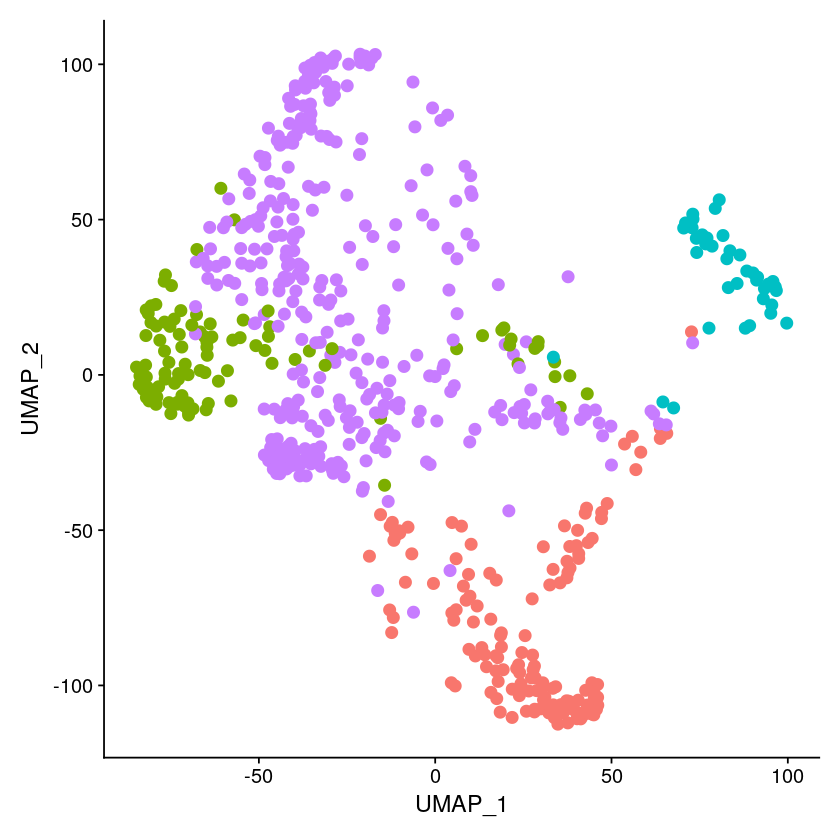

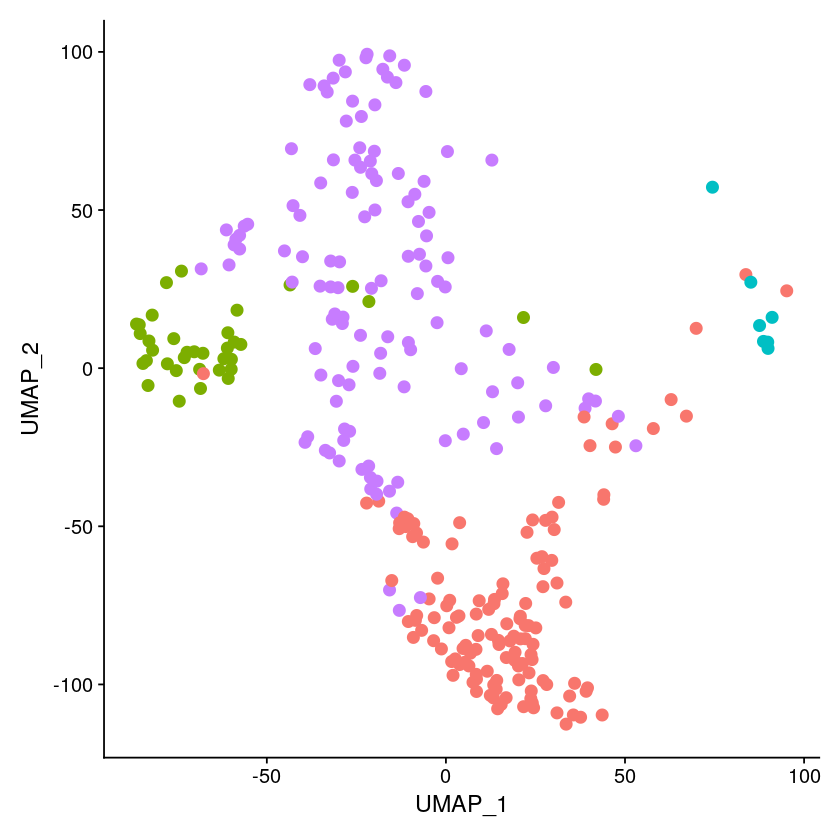

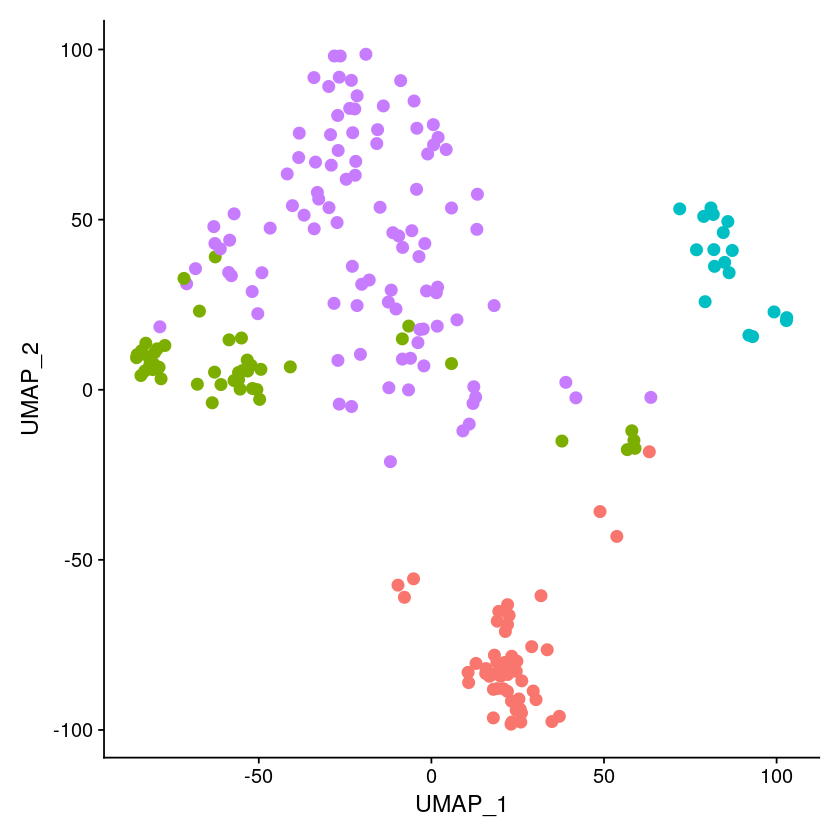

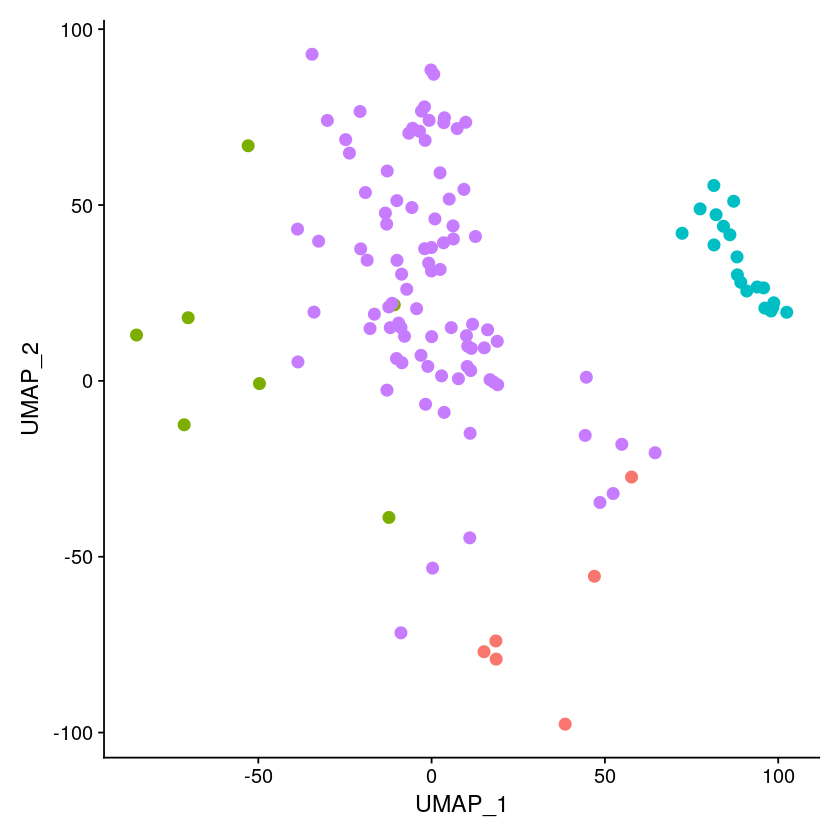

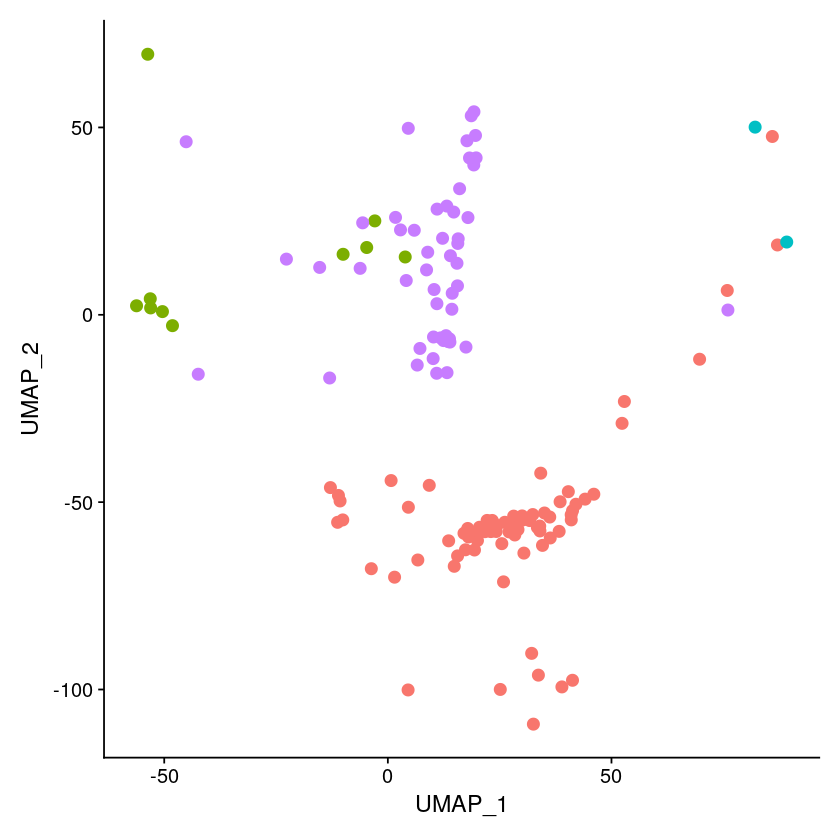

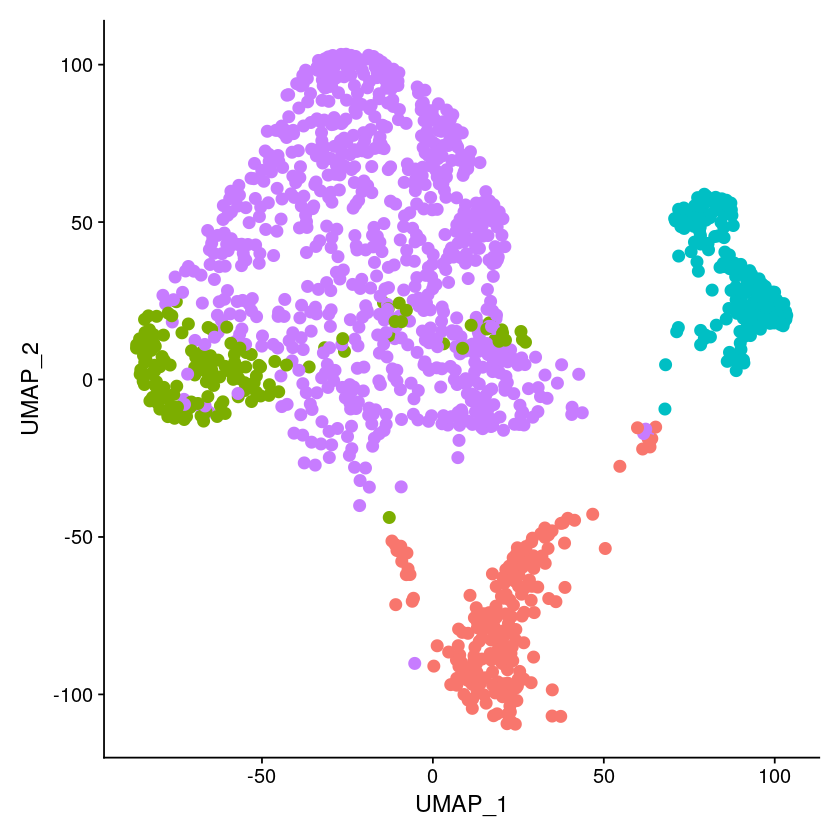

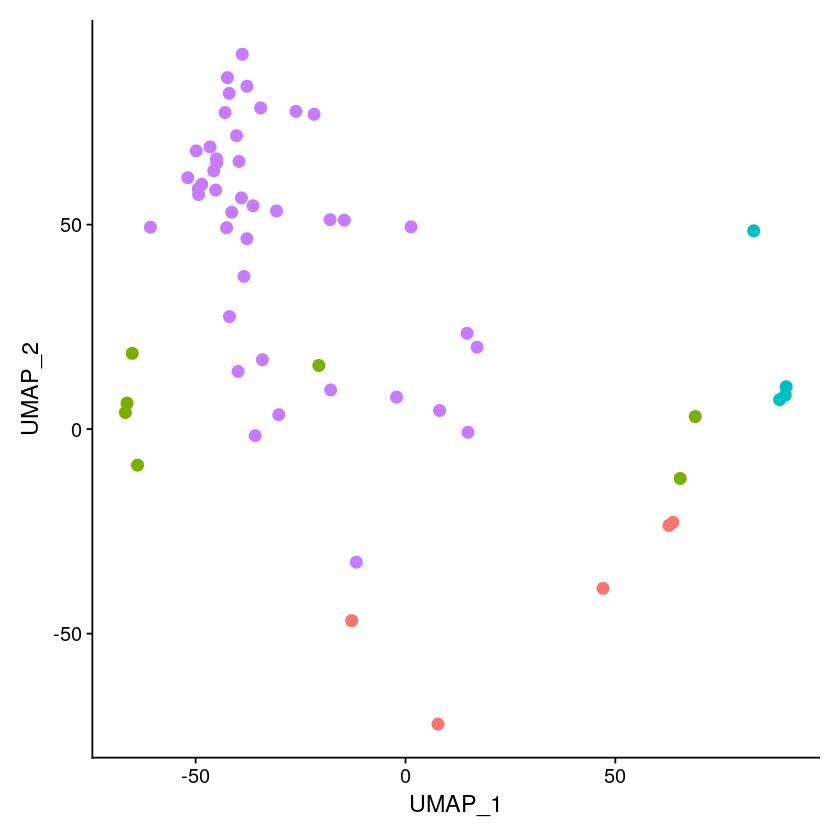

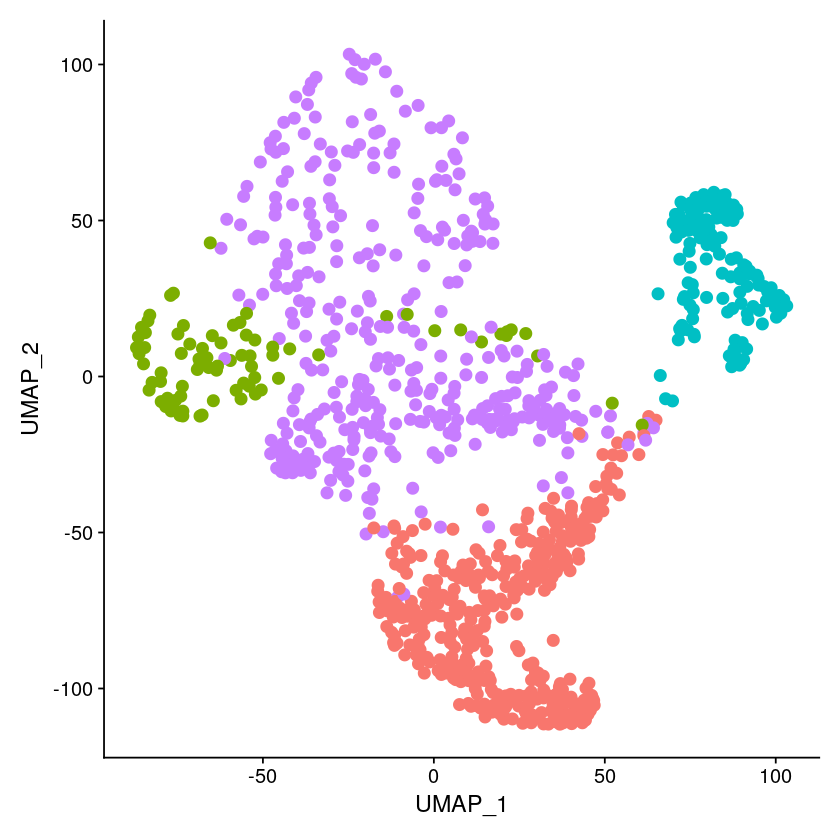

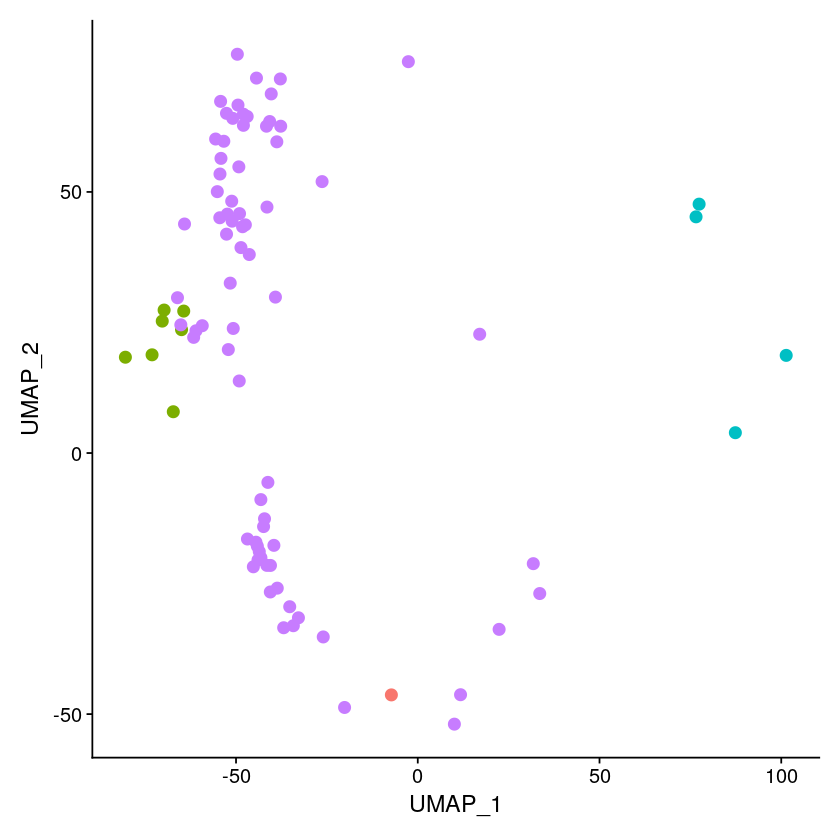

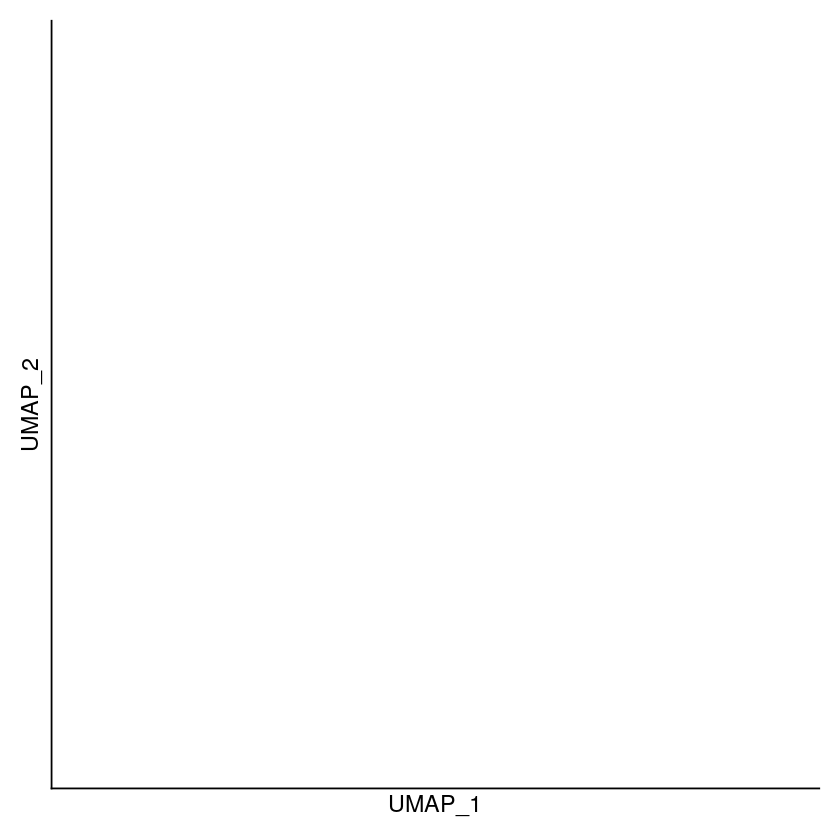

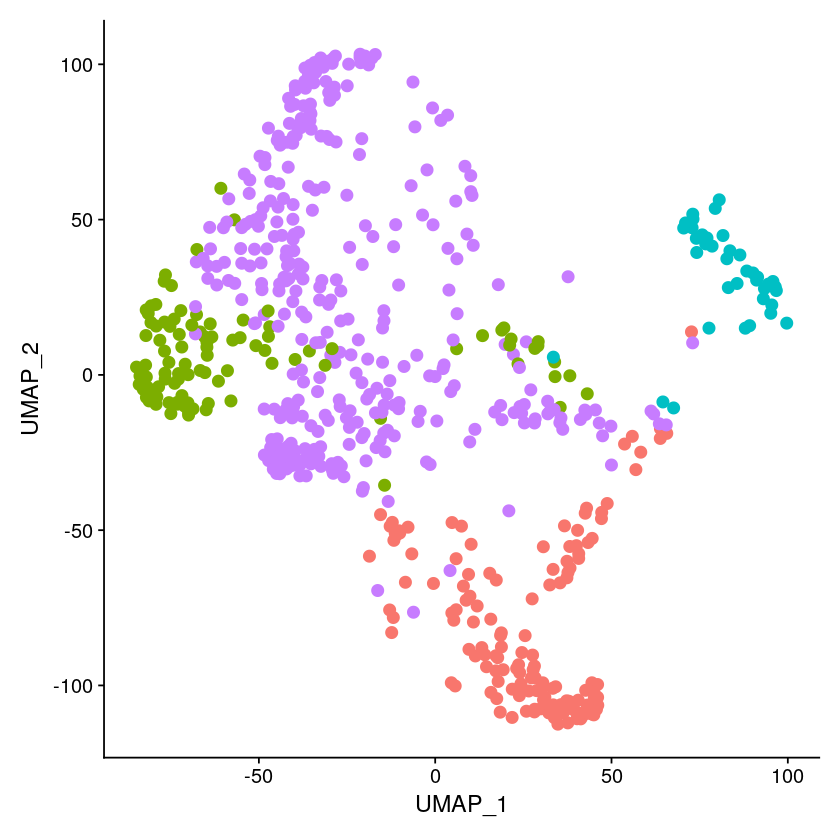

In [42]:
require(scales)

fates = sort(unique(adrenal_medulla$SR@meta.data$fate))
fate2col = hue_pal()(length(fates))
names(fate2col) = fates

#by sample
for(timepoint in unique(adrenal_medulla$SR@meta.data$orig.ident)){
    #print(paste0('figures/fig1/003a.adrenal_whole.timepoint.',timepoint,'.png'))
    plot(
        #DimPlot(adrenal_whole$SR[,adrenal_whole$SR@meta.data$orig.ident==timepoint], 
        #    reduction = "umap", group.by = 'fate2', pt.size=0.1, label=F) + NoLegend()
        DimPlot(adrenal_medulla$SR, cells = adrenal_medulla$SR@meta.data$orig.ident==timepoint,
            reduction = "umap", group.by = 'fate', pt.size=3, label=F,
            cols = fate2col) + NoLegend()
    )
    ggsave(paste0('figures/fig2_pk_take2_selbridge/003a.adrenal_medulla.sample.',timepoint,'.png'), width=5, height=5, dpi=320)
}

DimPlot(adrenal_medulla$SR, cells = adrenal_medulla$SR@meta.data$orig.ident %in% c('R63_w12GE', 'R63_w12GP'),
            reduction = "umap", group.by = 'fate', pt.size=3, label=F,
            cols = fate2col) + NoLegend()
ggsave(paste0('figures/fig2_pk_take2_selbridge/003a.adrenal_medulla.sample.','R63_w12_GE_GP','.png'), width=5, height=5, dpi=320)

DimPlot(adrenal_medulla$SR, cells = adrenal_medulla$SR@meta.data$orig.ident %in% c('R39_w95', 'R63_w95'),
            reduction = "umap", group.by = 'fate', pt.size=3, label=F,
            cols = fate2col) + NoLegend()
ggsave(paste0('figures/fig2_pk_take2_selbridge/003a.adrenal_medulla.sample.','R29_R63_w9','.png'), width=5, height=5, dpi=320)

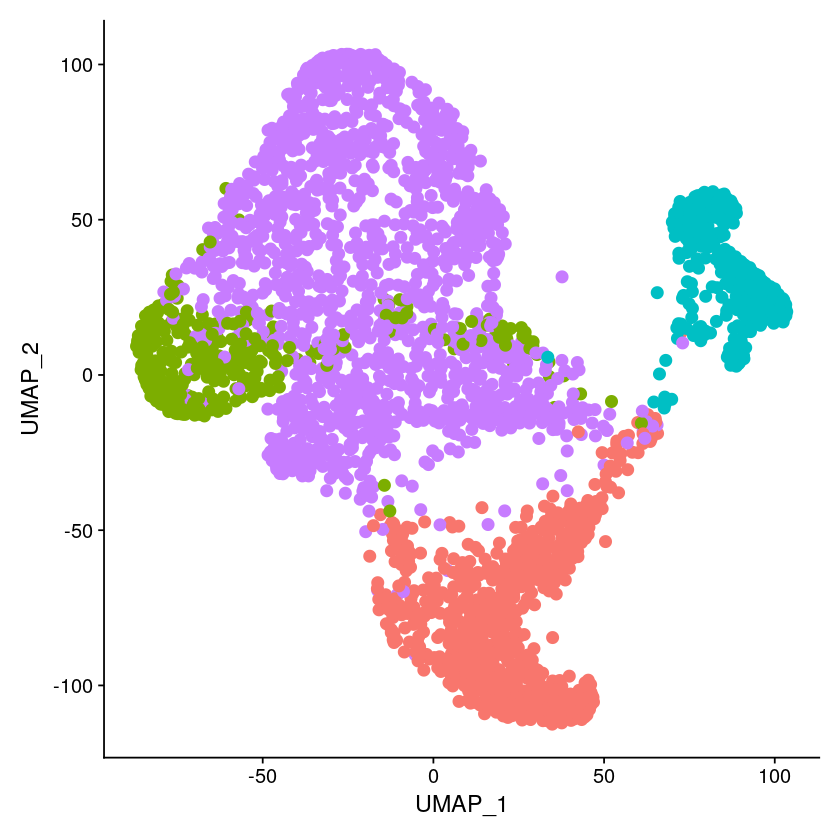

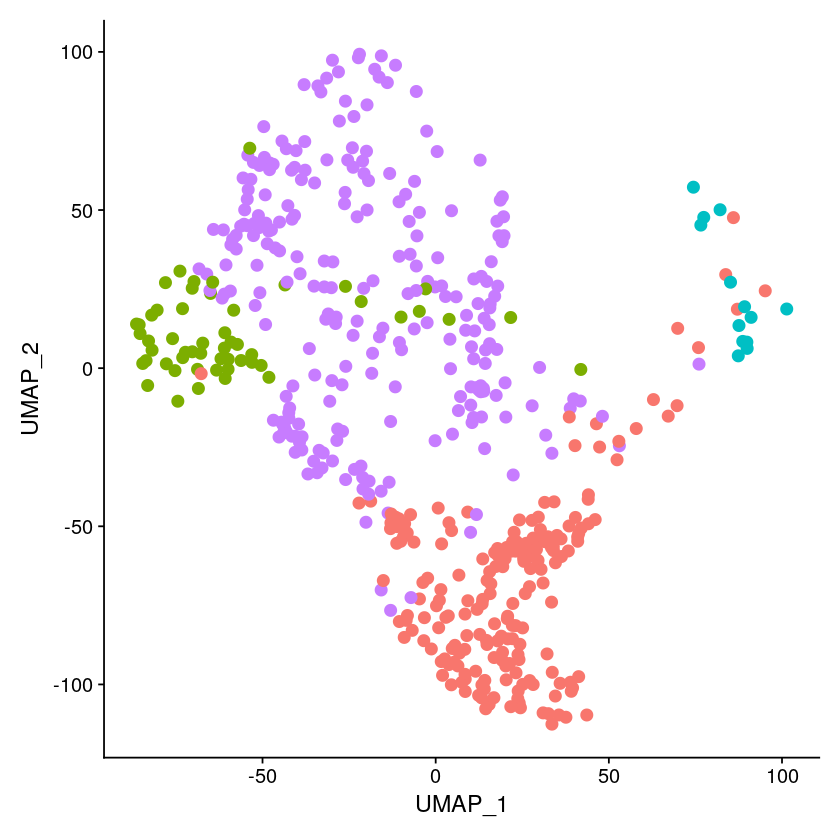

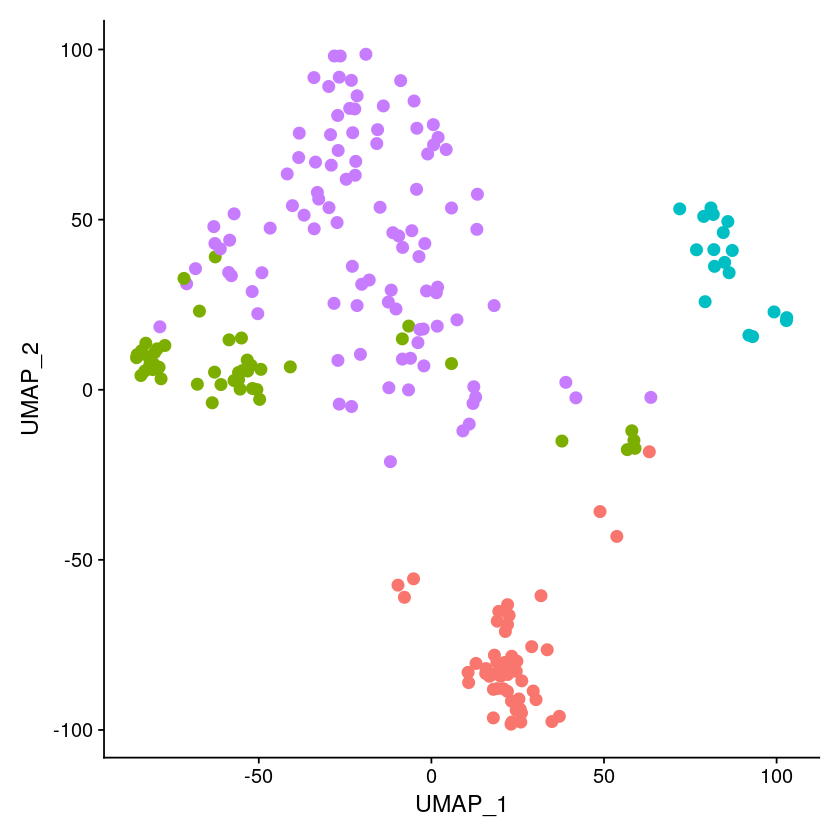

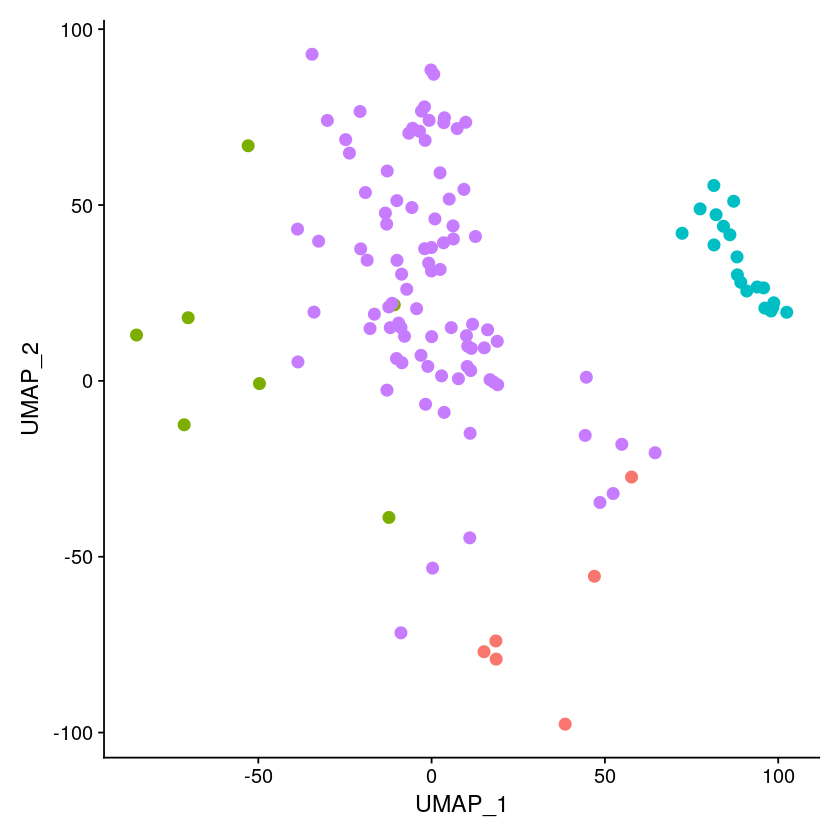

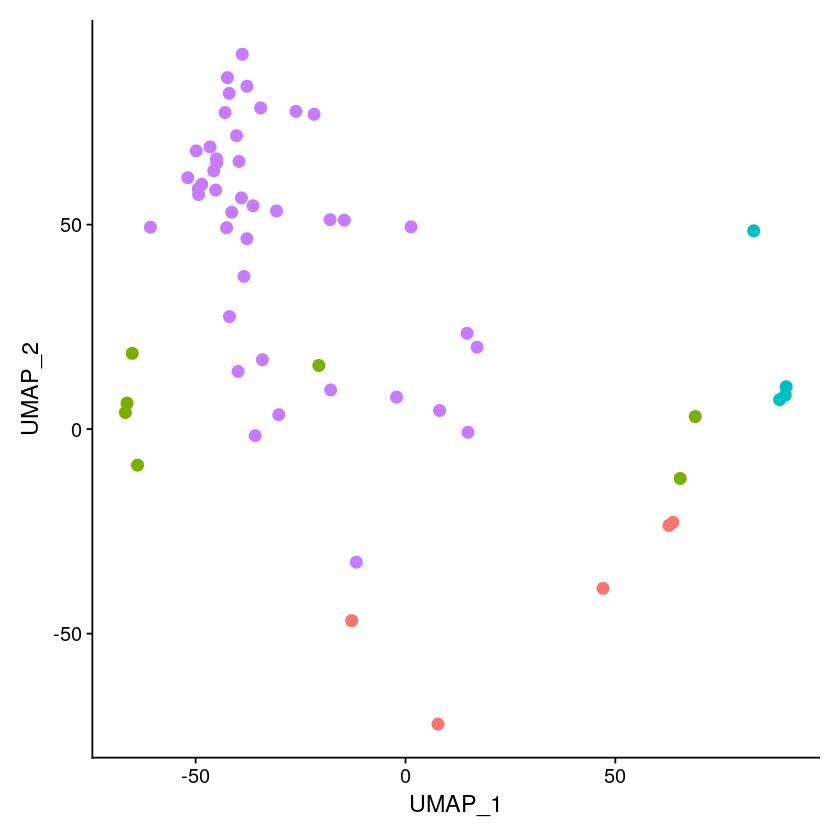

In [44]:
require(scales)

fates = sort(unique(adrenal_medulla$SR@meta.data$fate))
fate2col = hue_pal()(length(fates))
names(fate2col) = fates

#by sample
for(timepoint in unique(adrenal_medulla$SR@meta.data$timepoint)){
    #print(paste0('figures/fig1/003a.adrenal_whole.timepoint.',timepoint,'.png'))
    plot(
        #DimPlot(adrenal_whole$SR[,adrenal_whole$SR@meta.data$orig.ident==timepoint], 
        #    reduction = "umap", group.by = 'fate2', pt.size=0.1, label=F) + NoLegend()
        DimPlot(adrenal_medulla$SR, cells = adrenal_medulla$SR@meta.data$timepoint==timepoint,
            reduction = "umap", group.by = 'fate', pt.size=3, label=F,
            cols = fate2col) + NoLegend()
    )
    ggsave(paste0('figures/fig2_pk_take2_selbridge/003b.adrenal_medulla.timepoint.',timepoint,'.png'), width=5, height=5, dpi=320)
}


# Visualize the bridges between sympathoblasts and chromaffin cells

Warning message in readLines("../data/embeddings/bridge_and_fork.cells.p2"):
“incomplete final line found on '../data/embeddings/bridge_and_fork.cells.p2'”
Warning message in readLines("../data/embeddings/bridge_and_fork.cells.p2"):
“incomplete final line found on '../data/embeddings/bridge_and_fork.cells.p2'”
Warning message in readLines("../data/embeddings/bridge_and_fork.cells.p2"):
“incomplete final line found on '../data/embeddings/bridge_and_fork.cells.p2'”


other      fork    bridge 
   "gray" "#8000ff" "#ff1000"

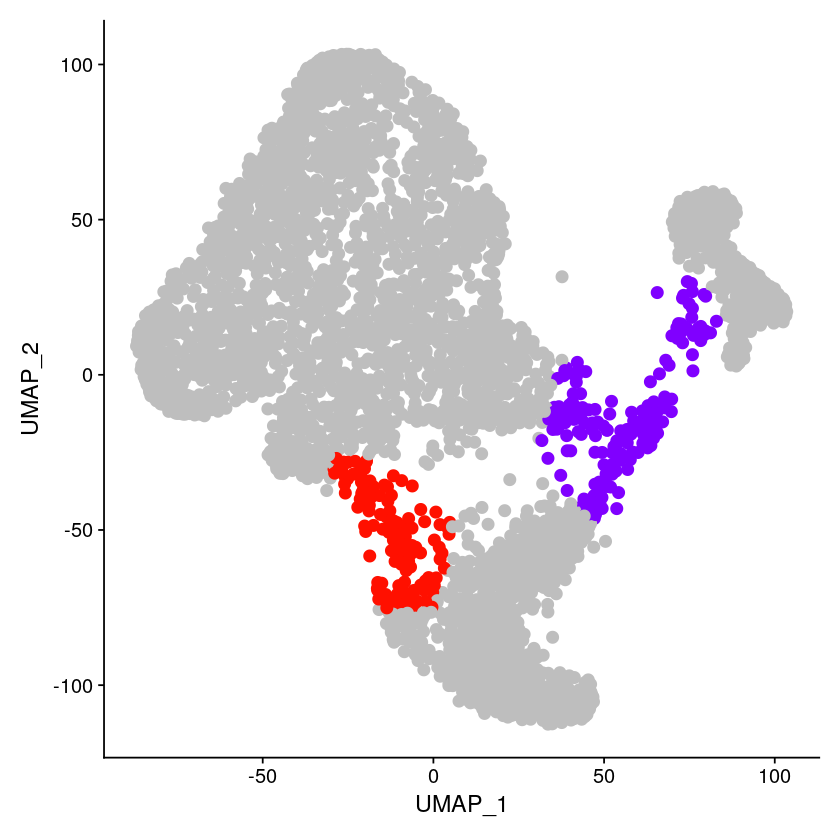

In [65]:
#fork and bridge
cells_fork_bridge = lapply( readLines('../data/embeddings/bridge_and_fork.cells.p2'), 
                           function(l){
                               v = strsplit(l, ',')[[1]]
                               v[3:length(v)]
                           } )

names(cells_fork_bridge) = sapply( readLines('../data/embeddings/bridge_and_fork.cells.p2'), 
                           function(l){
                               v = strsplit(l, ',')[[1]]
                               v[2]
                           } )
colors_fork_bridge = sapply( readLines('../data/embeddings/bridge_and_fork.cells.p2'), 
                           function(l){
                               v = strsplit(l, ',')[[1]]
                               v[1]
                           } )
#cells_fork_bridge
#colors_fork_bridge

#fate2col = c('gray', paste0('#', colors_fork_bridge))
#fate2col = c('gray', paste0('#', colors_fork_bridge))
fate2col = c('gray', '#8000ff', '#ff1000')
names(fate2col) = c('other', names(cells_fork_bridge))
fate2col

adrenal_medulla$SR@meta.data$fork_bridge = rep('other', nrow(adrenal_medulla$SR@meta.data))
adrenal_medulla$SR@meta.data$fork_bridge[colnames(adrenal_medulla$SR) %in% cells_fork_bridge[[1]] ] = names(cells_fork_bridge)[1]
adrenal_medulla$SR@meta.data$fork_bridge[colnames(adrenal_medulla$SR) %in% cells_fork_bridge[[2]] ] = names(cells_fork_bridge)[2]

DimPlot(adrenal_medulla$SR,
            reduction = "umap", group.by = 'fork_bridge', pt.size=3, label=F,
            cols = fate2col) + NoLegend()
ggsave('figures/fig2_pk_take2_selbridge/007.adrenal_medulla.fork_bridge.png', width=5, height=5, dpi=320)

In [178]:
# number of cells in a cell type per sample and per timepoint

table(adrenal_medulla$SR@meta.data$orig.ident, adrenal_medulla$SR@meta.data$fate)

table(adrenal_medulla$SR@meta.data$timepoint, adrenal_medulla$SR@meta.data$fate)

           
            chromaffin cycling SCP sympathoblasts
  R30_w85          129      36   7            123
  R39_w95          145     102  38            348
  R48a_w145         52      46  18            100
  R48b_w120          6       7  19             88
  R48c_w85          75      10   2             50
  R53a_w95         204     153 170            794
  R53b_w115          5       7   4             43
  R53c_w95         386      82 151            384
  R62_w85            1       7   4             73

    
     chromaffin cycling  SCP sympathoblasts
  8         205      53   13            246
  9         735     337  359           1526
  11          5       7    4             43
  12          6       7   19             88
  14         52      46   18            100

In [179]:
# number of cells in the bridges type per sample and per timepoint

table(adrenal_medulla$SR@meta.data$orig.ident, adrenal_medulla$SR@meta.data$fork_bridge)
table(adrenal_medulla$SR@meta.data$timepoint, adrenal_medulla$SR@meta.data$fork_bridge)

           
            bridge fork other
  R30_w85       29   16   250
  R39_w95       26   36   571
  R48a_w145      3   12   201
  R48b_w120      3    7   110
  R48c_w85       9    5   123
  R53a_w95      20   27  1274
  R53b_w115      2    5    52
  R53c_w95      60   83   860
  R62_w85        3    2    80

    
     bridge fork other
  8      41   23   453
  9     106  146  2705
  11      2    5    52
  12      3    7   110
  14      3   12   201

# Export pagoda2 object

In [21]:
SR = adrenal_medulla$SR

library(pagoda2)
library(igraph)

p2 <- basicP2proc(SR@assays$RNA@counts, n.cores = 1)

go.env <- p2.generate.human.go(p2)


p2$clusters$PCA$seurat_cluster = as.factor(SR@meta.data$seurat_cluster)
names(p2$clusters$PCA$seurat_cluster) = rownames(SR@meta.data)

p2$embeddings$PCA$tSNE = as.matrix(SR@reductions$umap@cell.embeddings)
    #p2$embeddings$PCA = as.matrix(p2$embeddings$PCA@cell.embeddings)

p2$clusters$PCA$timepoint = as.factor(SR@meta.data$orig.ident)
names(p2$clusters$PCA$timepoint) = rownames(SR@meta.data)

p2$embeddings$PCA$tSNE = as.matrix(SR@reductions$umap@cell.embeddings)
    #p2$embeddings$PCA = as.matrix(p2$embeddings$PCA@cell.embeddings)


n.cores=1

cat('Calculating hdea...\n')
hdea <- p2$getHierarchicalDiffExpressionAspects(type='PCA',clusterName='multilevel',z.threshold=3, n.cores = n.cores)

extraWebMetadata = NULL
app.title = 'adrenal_medulla'
metadata.forweb <- list();
metadata.forweb$timepoint <- p2.metadata.from.factor(p2$clusters$PCA$timepoint,displayname='timepoint')
metadata.forweb$leiden <- p2.metadata.from.factor(p2$clusters$PCA$seurat_cluster,displayname='seurat_cluster')
metadata.forweb$multilevel <- p2.metadata.from.factor(p2$clusters$PCA$multilevel,displayname='multilevel')
metadata.forweb <- c(metadata.forweb, extraWebMetadata)
genesets <- hierDiffToGenesets(hdea)
appmetadata = list(apptitle=app.title)
cat('Making KNN graph...\n')
#p2$makeGeneKnnGraph(n.cores=n.cores)
p2w = make.p2.app(p2, additionalMetadata = metadata.forweb, geneSets = genesets, dendrogramCellGroups = p2$clusters$PCA$multilevel, show.clusters=F, appmetadata = appmetadata)

dir.create('data/pagoda/')
p2w$serializeToStaticFast(binary.filename = 'data/pagoda/human_adrenal_PK.SR.bin')

3869 cells, 26105 genes; normalizing ... using plain model winsorizing ... log scale ... done.
calculating variance fit ... using gam 850 overdispersed genes ... 850persisting ... done.
running PCA using 3000 OD genes .... done
Estimating embeddings.
running tSNE using 1 cores:


Calculating hdea...
using multilevel  clustering for PCA space
Making KNN graph...


NULL